In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]


!pip install gym==0.9.7

!pip uninstall pyglet -y

!pip install pyglet==1.2.4

In [3]:
gym.__version__

'0.9.7'

In [4]:
import matplotlib
matplotlib.__version__

'2.1.0'

In [5]:
def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72,frames[0].shape[0]/72),dpi=72)
    patch=plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim=animation.FuncAnimation(plt.gcf(),animate,frames=len(frames),interval=50)
    anim.save('movie_cartpole.mp4')
    display(display_animation(anim,default_mode='loop'))

In [6]:
frames=[]
env=gym.make('CartPole-v0')
observation=env.reset()
for step in range(0,200):
    frames.append(env.render(mode='rgb_array'))
    action=np.random.choice(2)
    observation,reward,done,info=env.step(action)

C:\Users\USER\anaconda3\envs\rl_env36\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



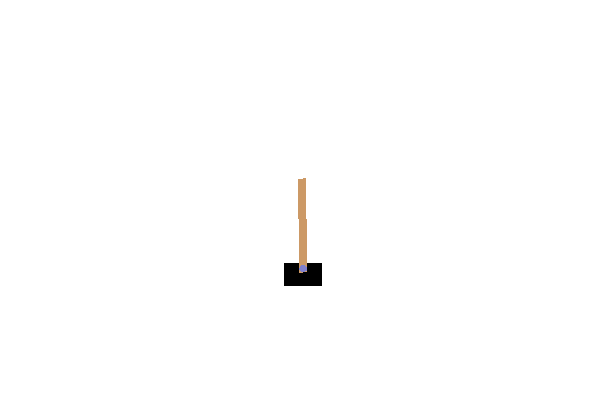
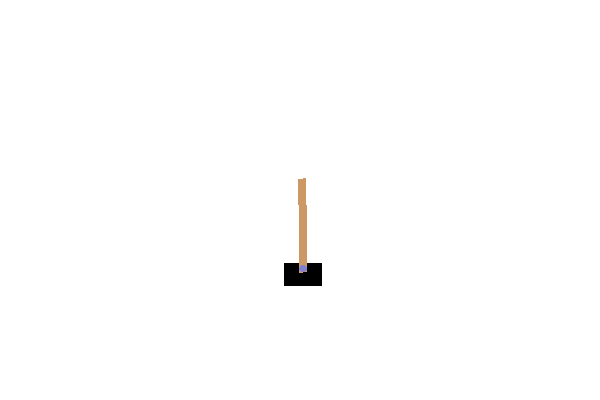
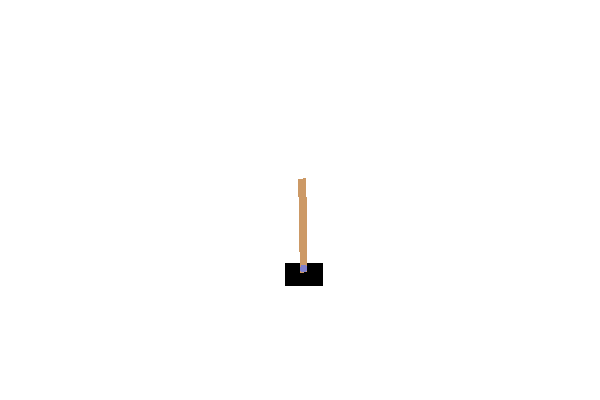
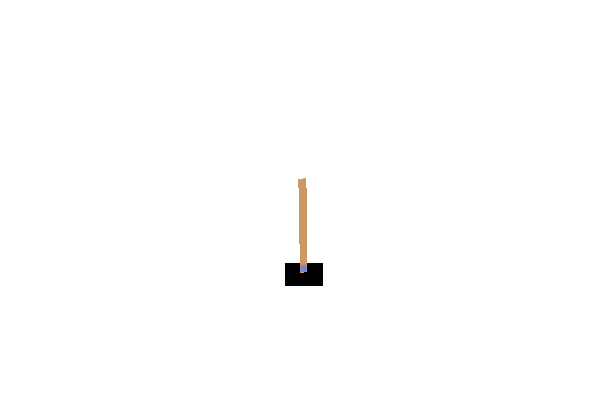
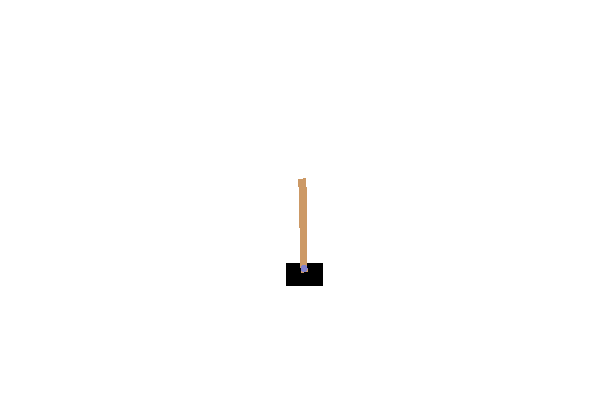
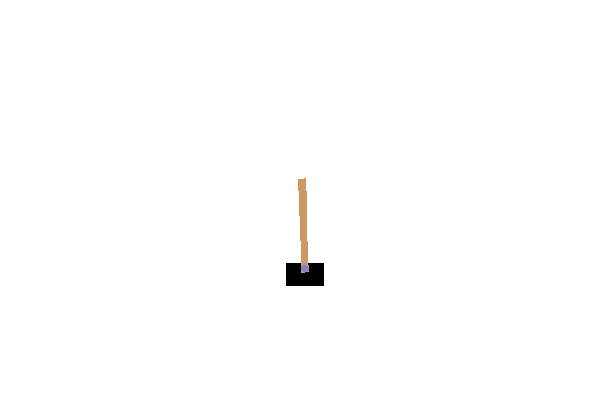
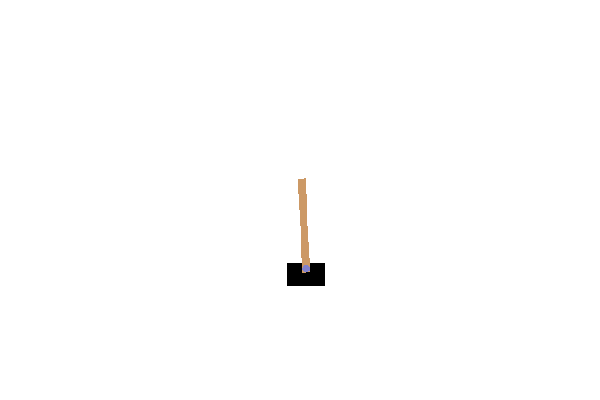
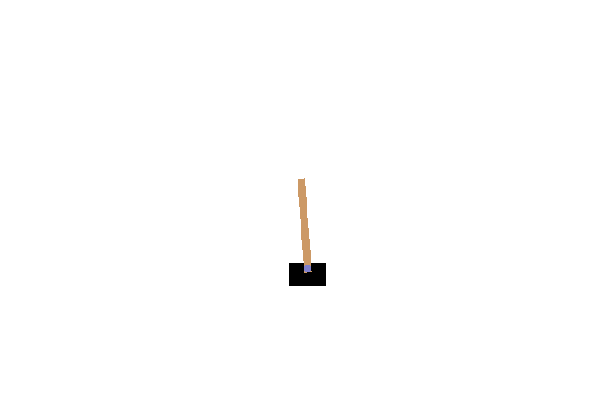
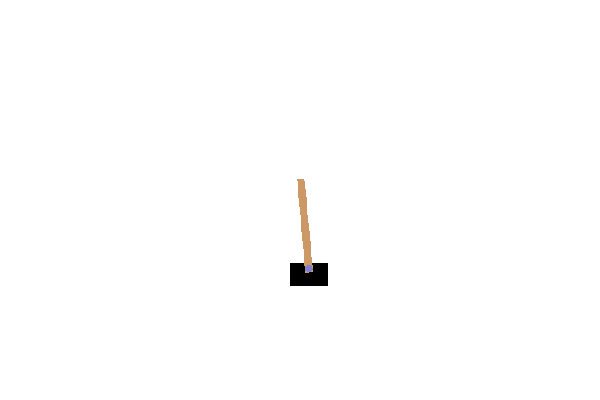
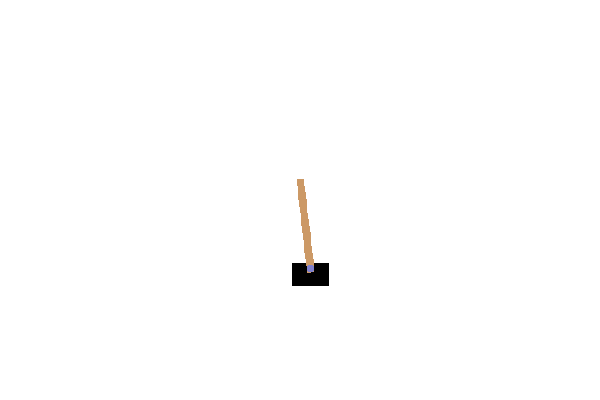
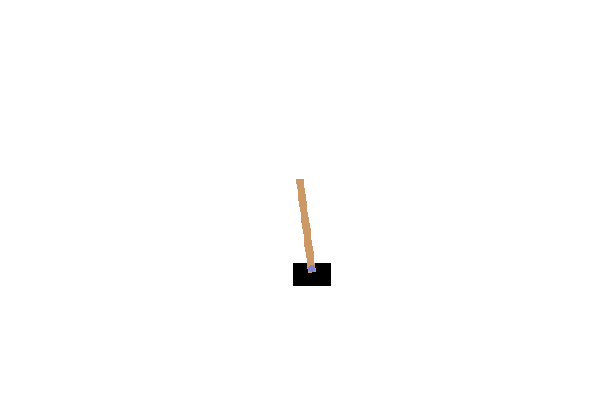
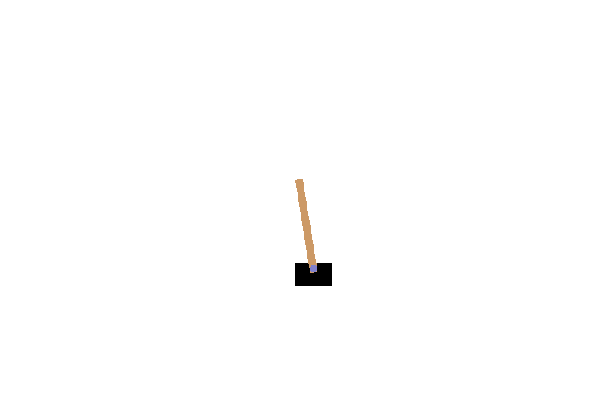
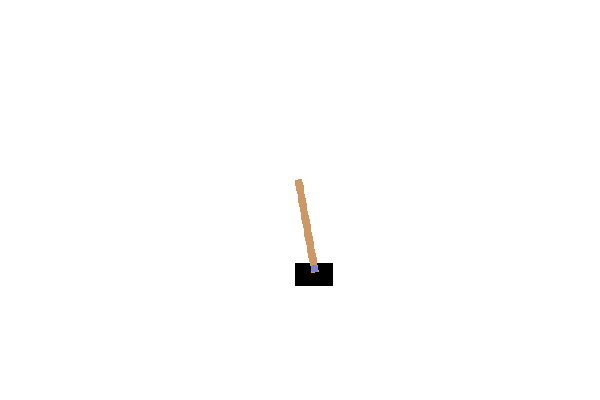
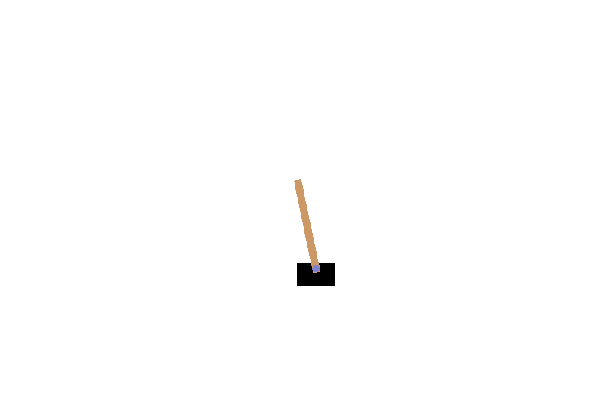
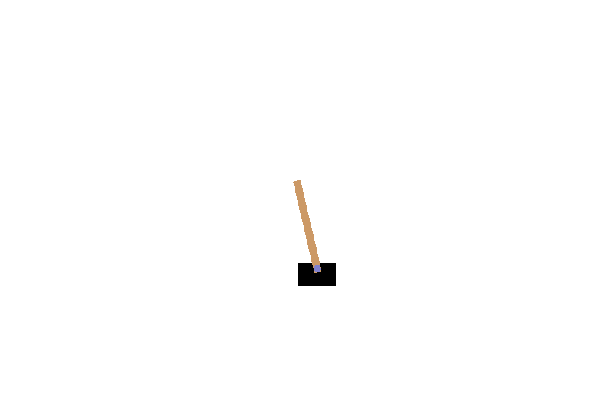
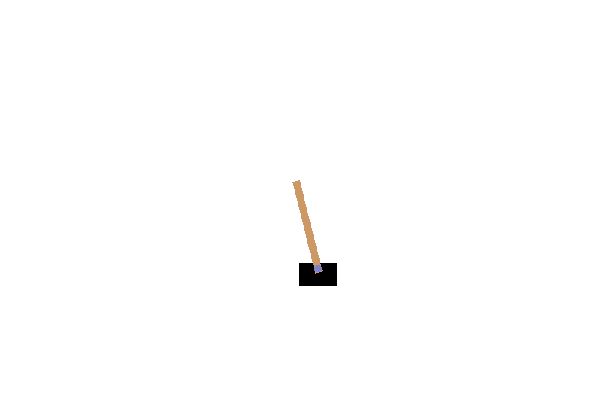
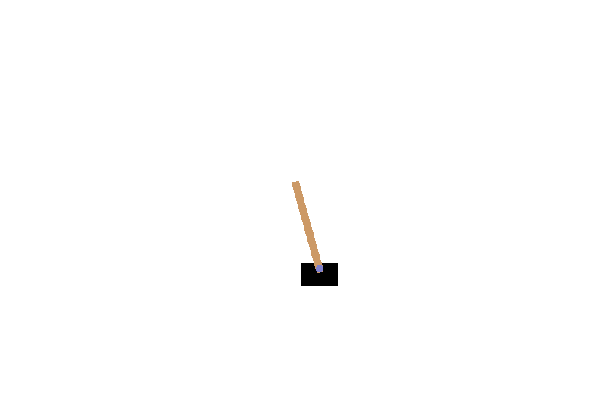
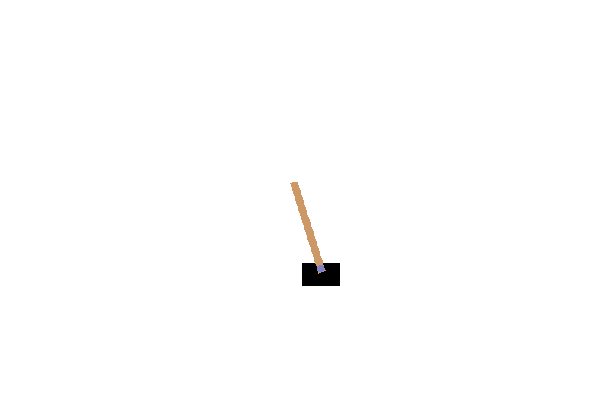
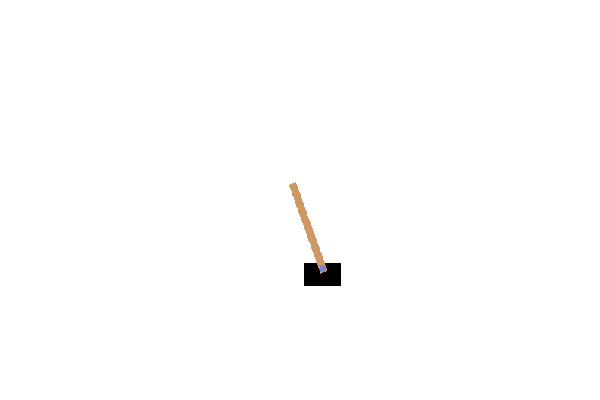
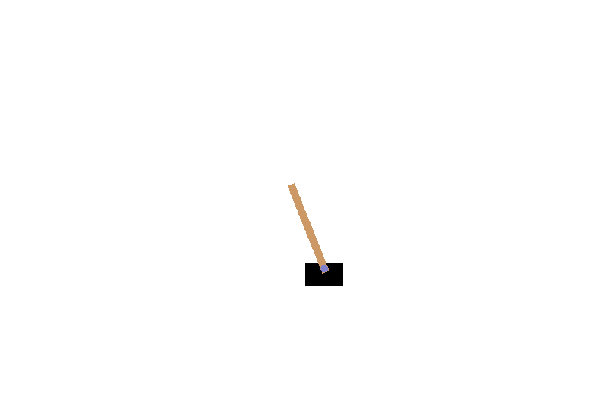
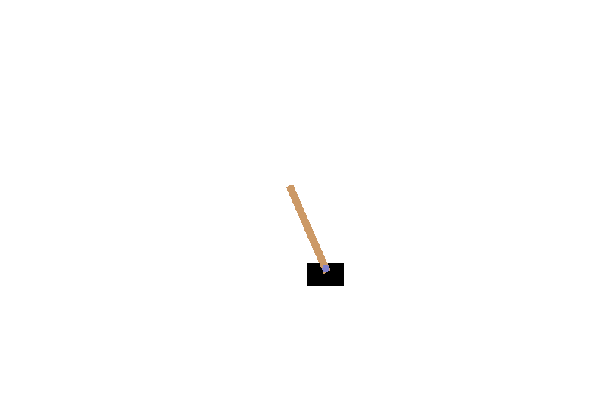
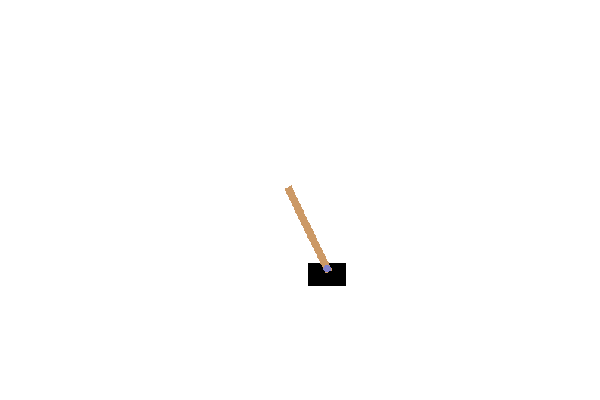
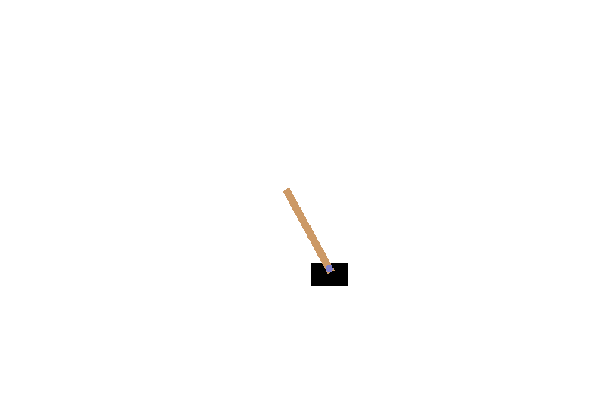
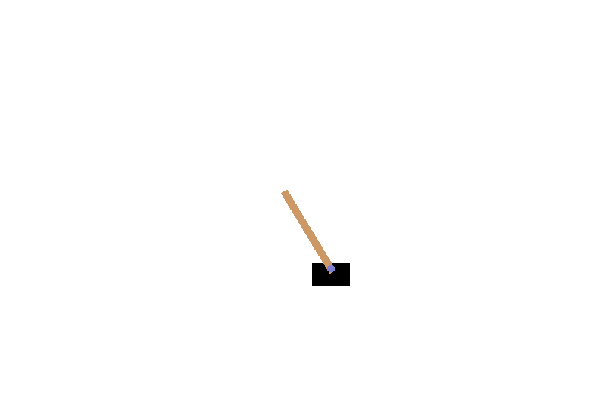
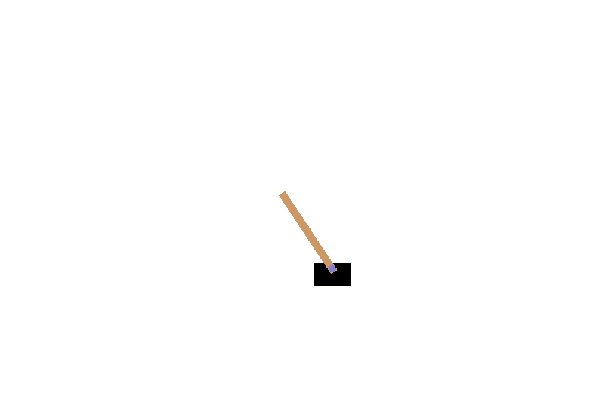
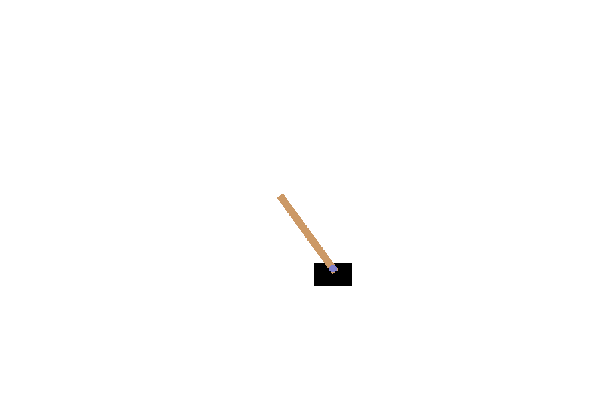
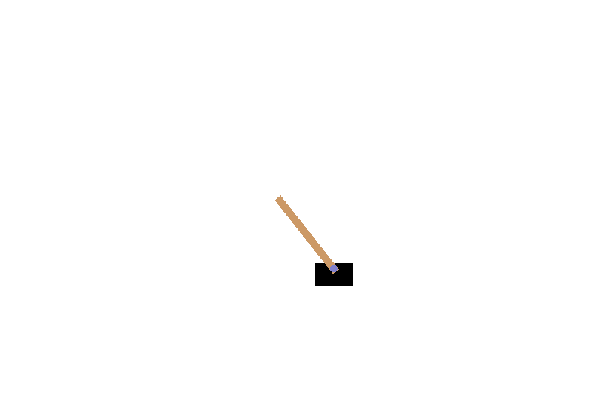
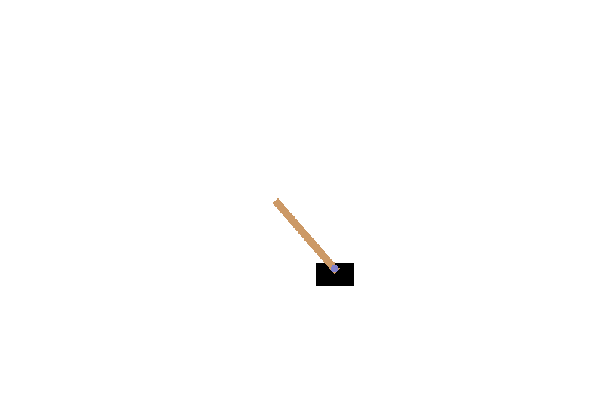
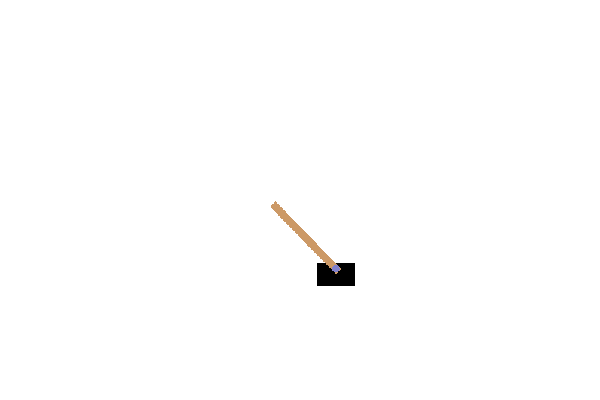
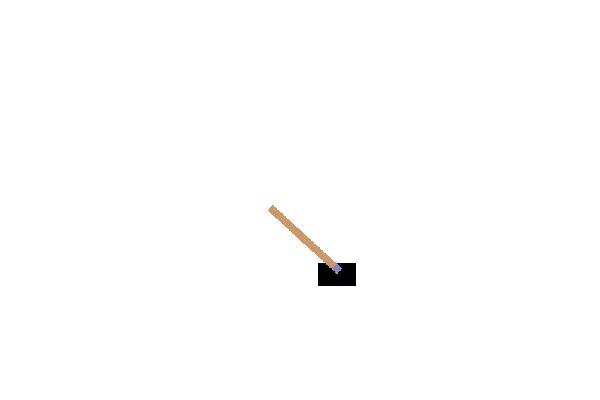
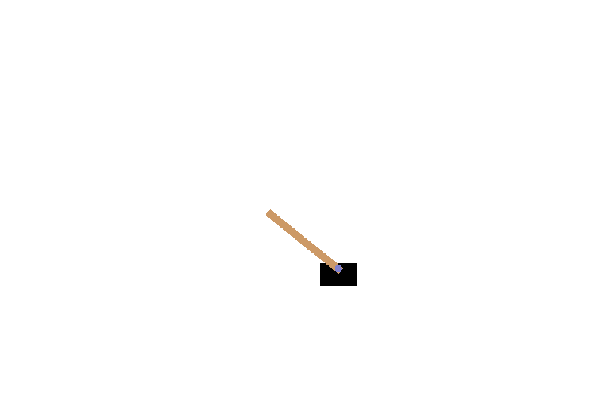
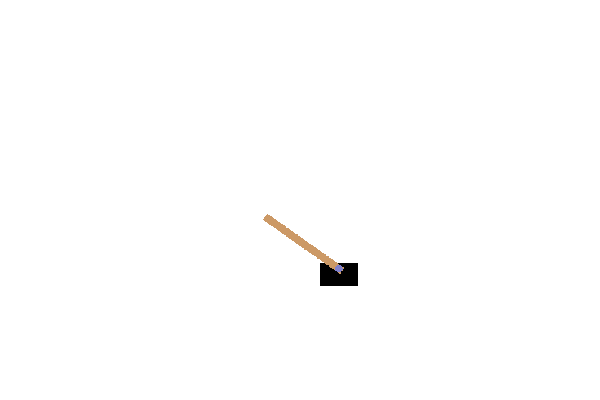
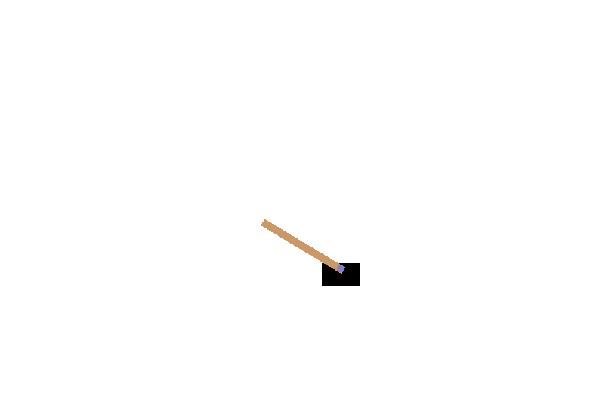
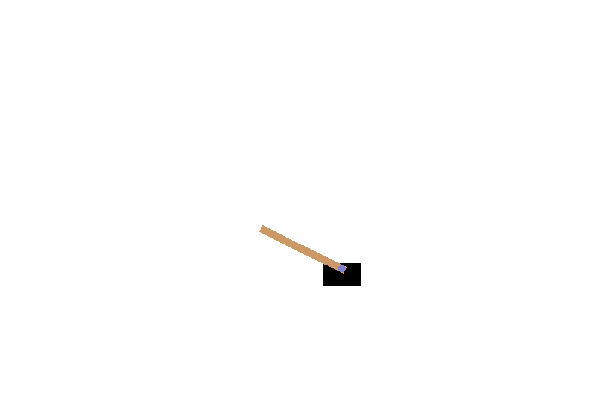
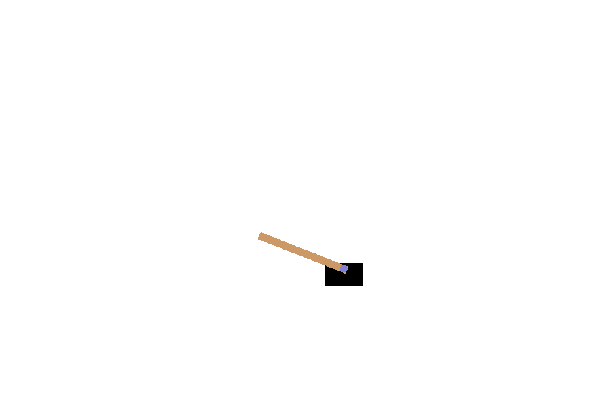
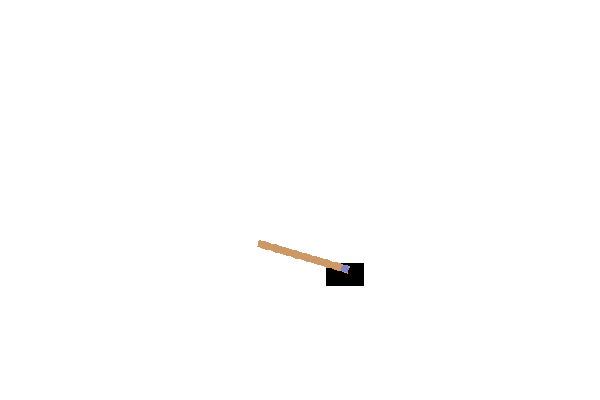
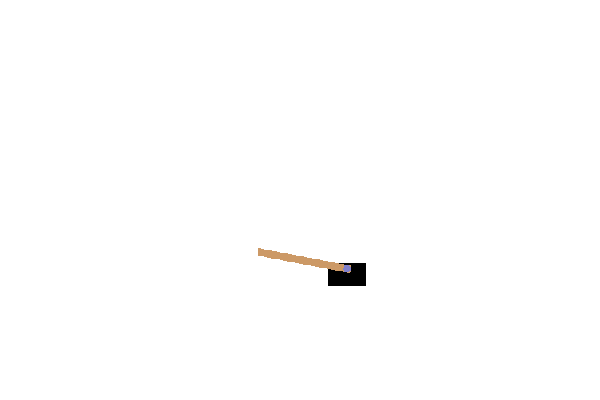
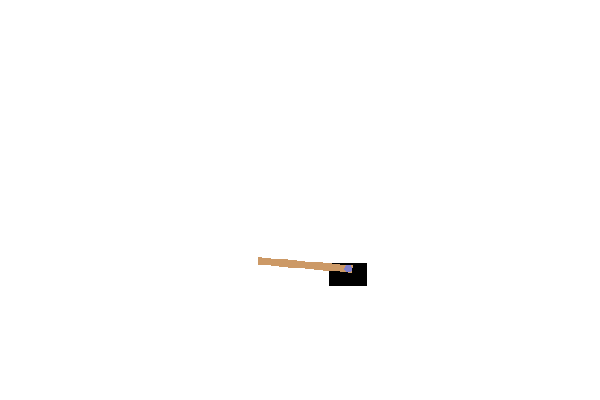
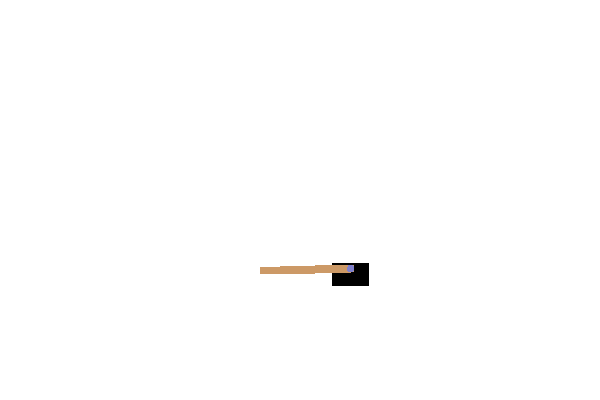
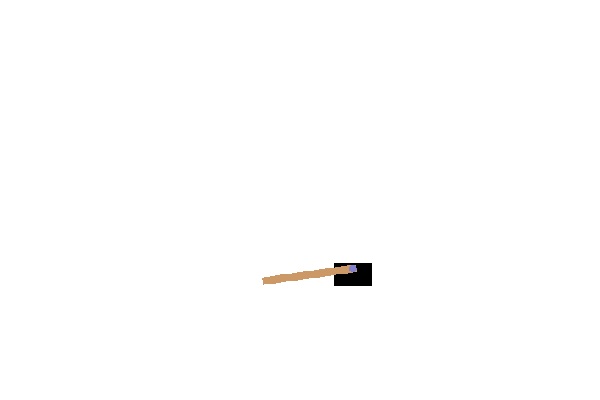
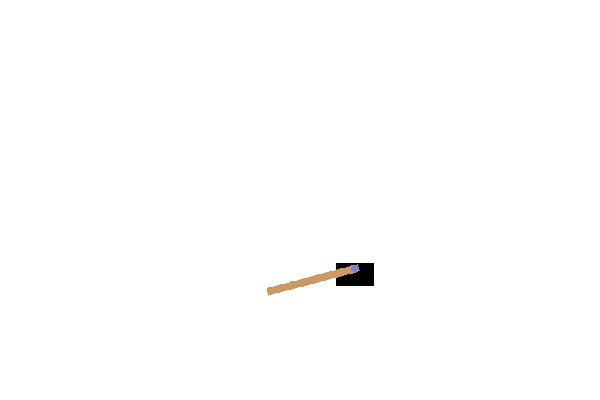
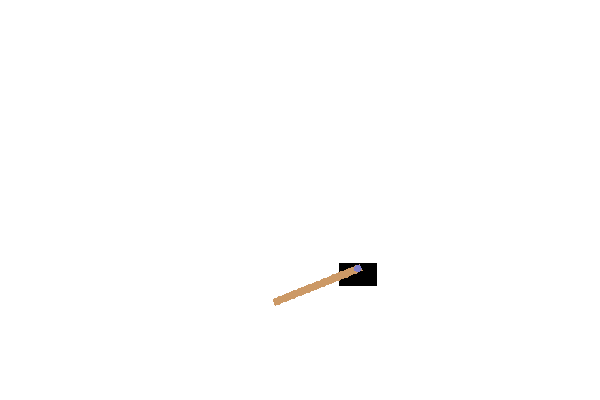
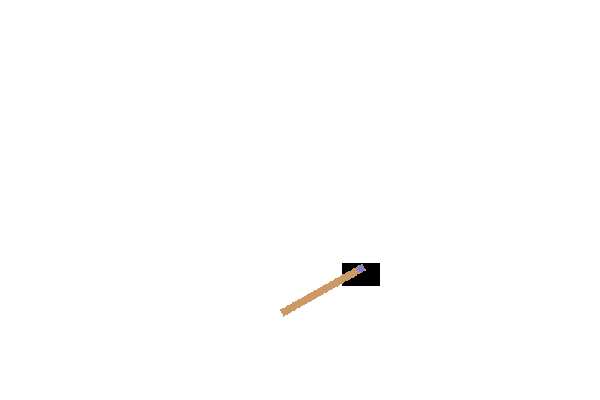
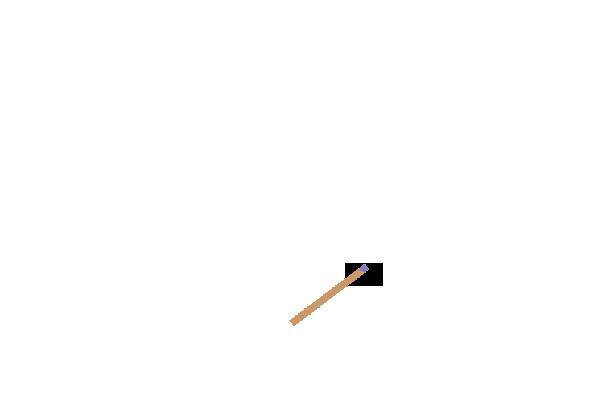
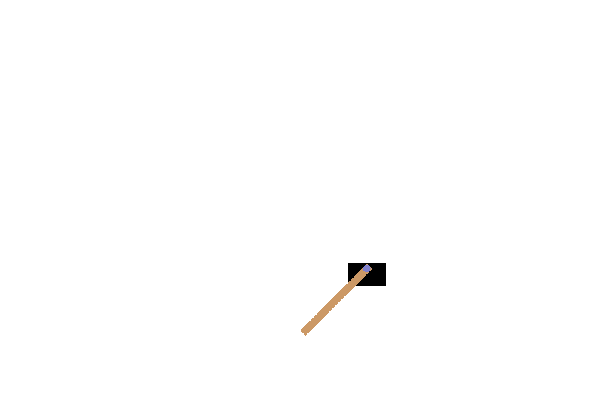
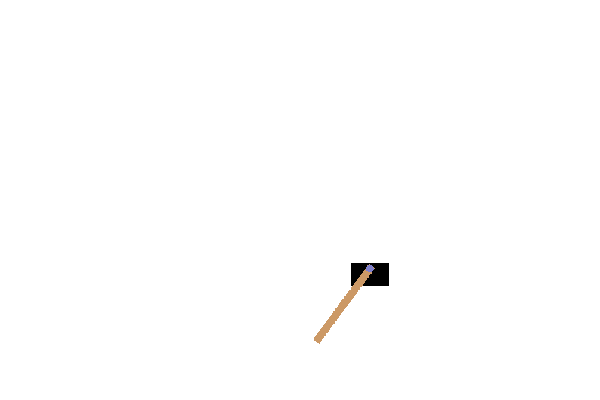
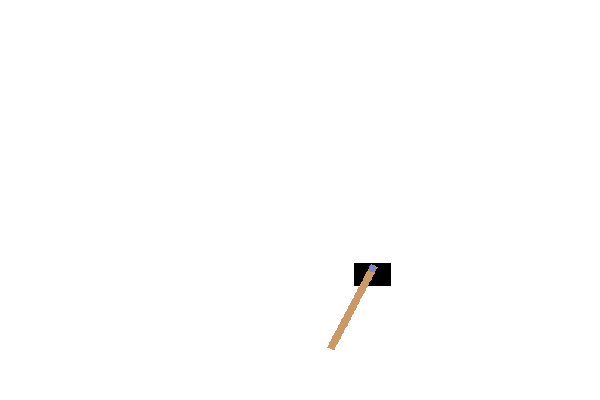
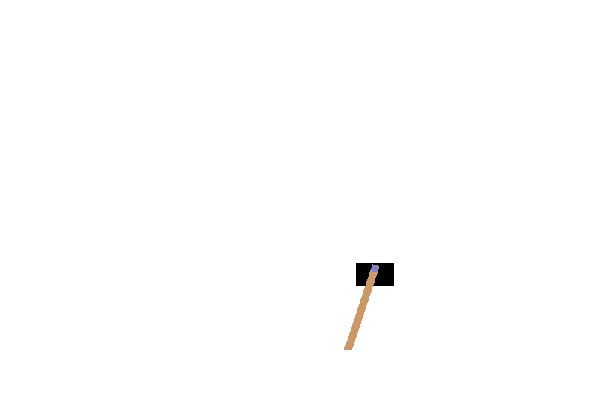
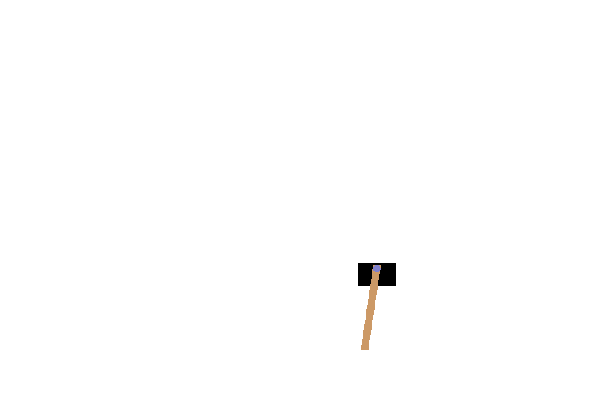
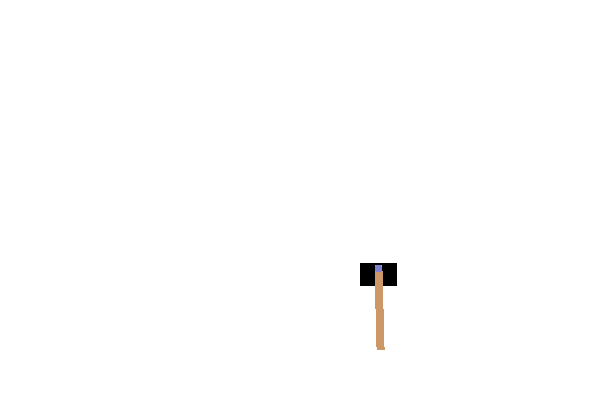
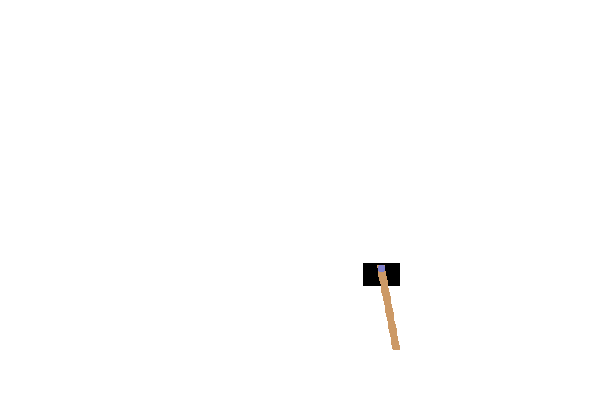
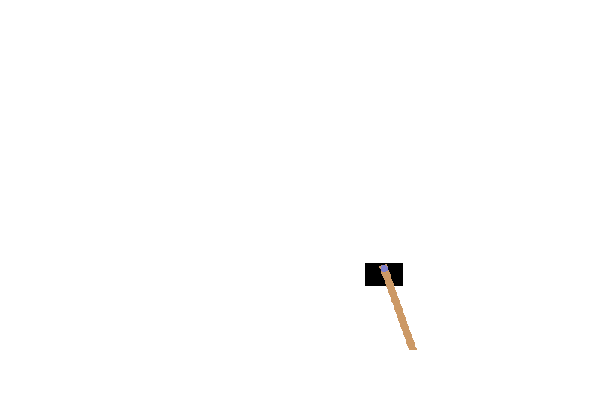
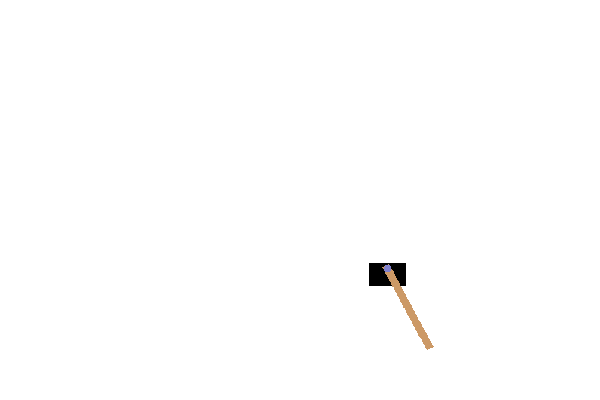
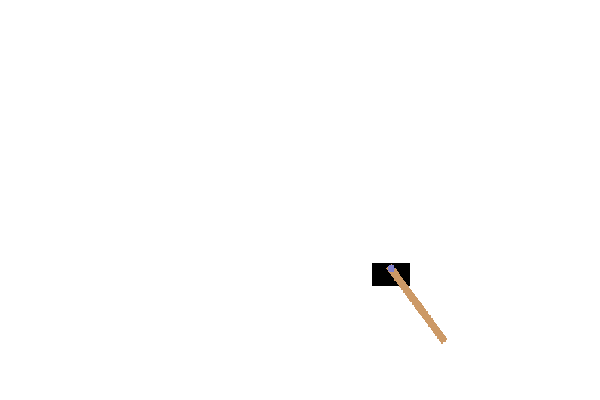
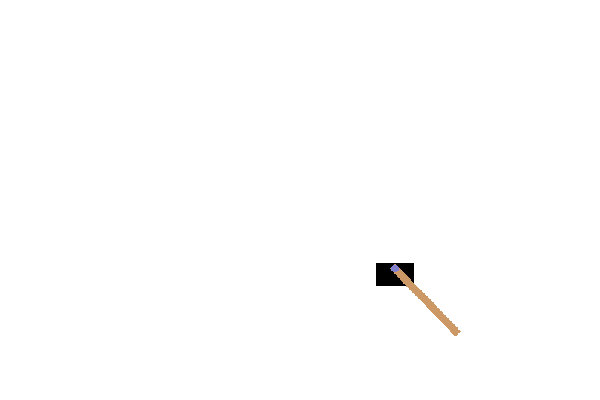
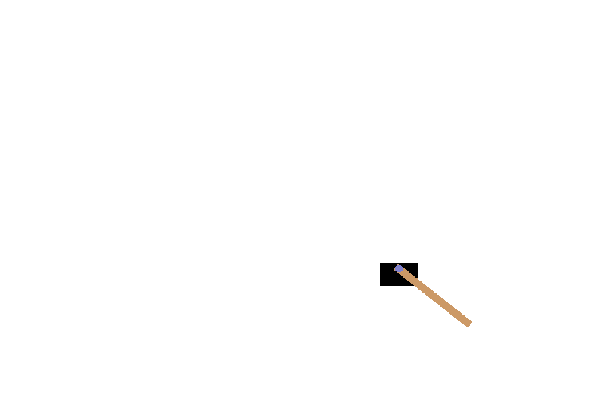
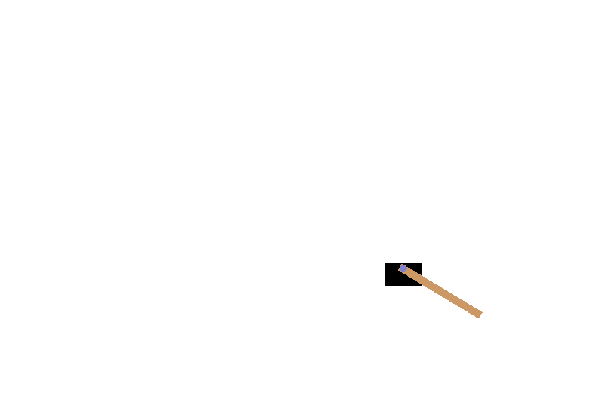
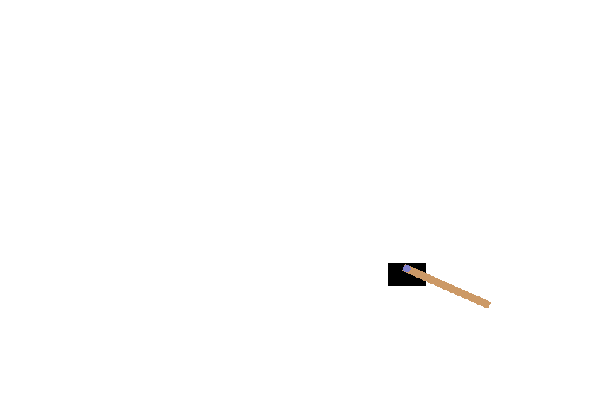
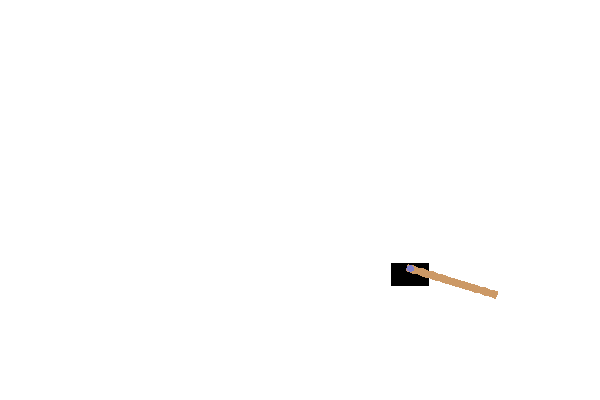
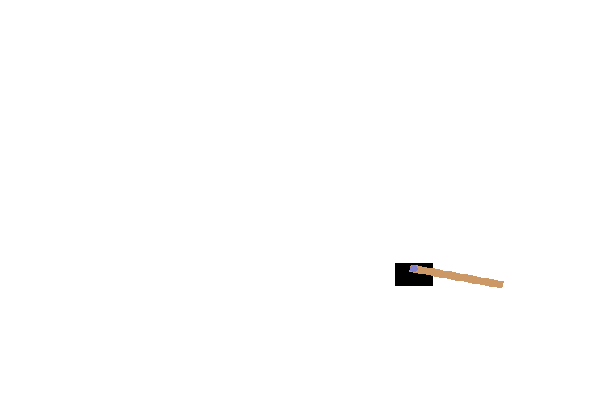
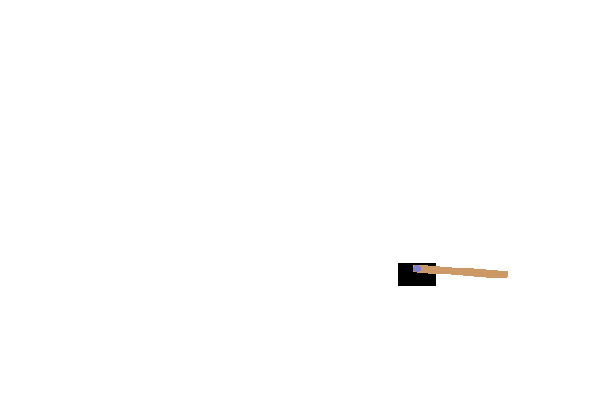
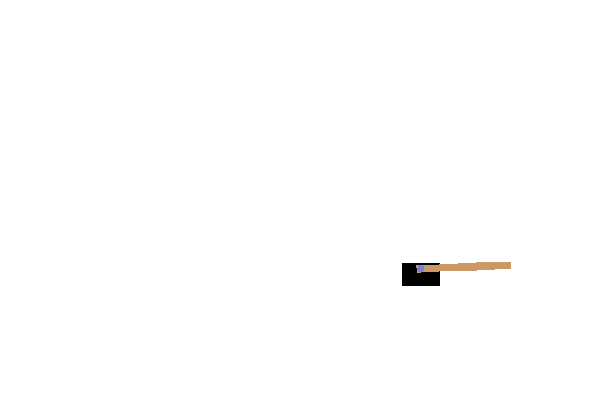
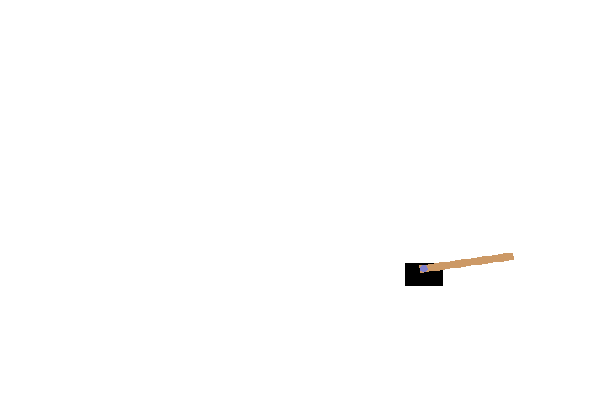
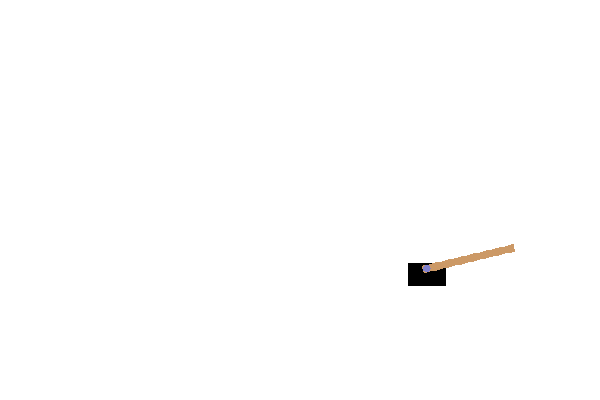
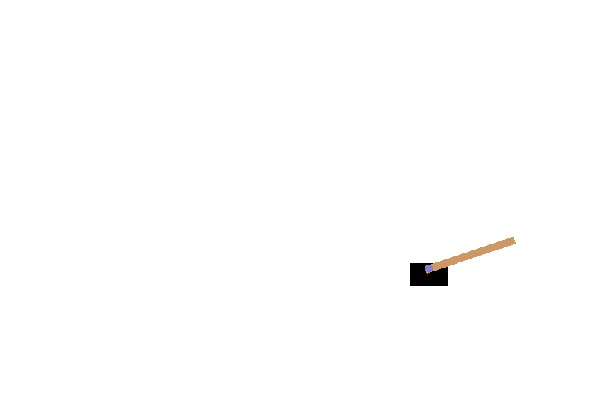
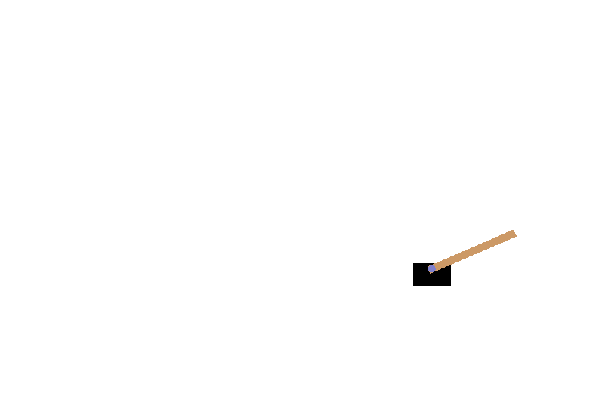
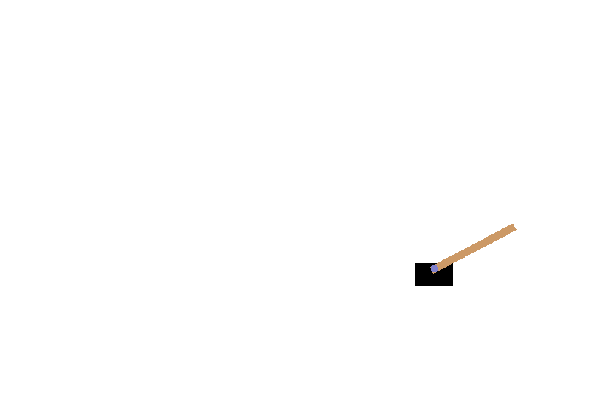
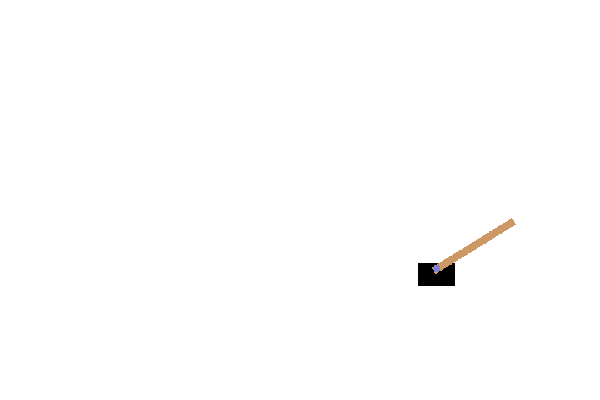
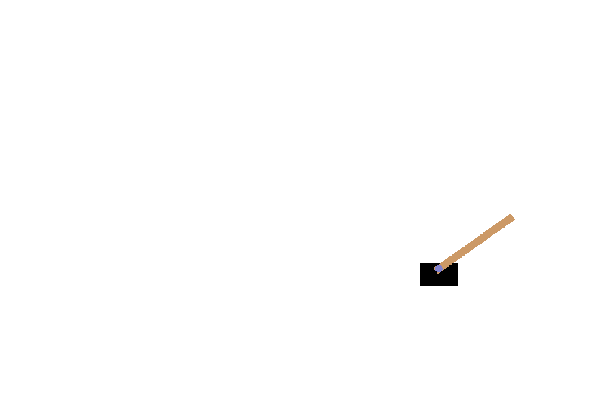
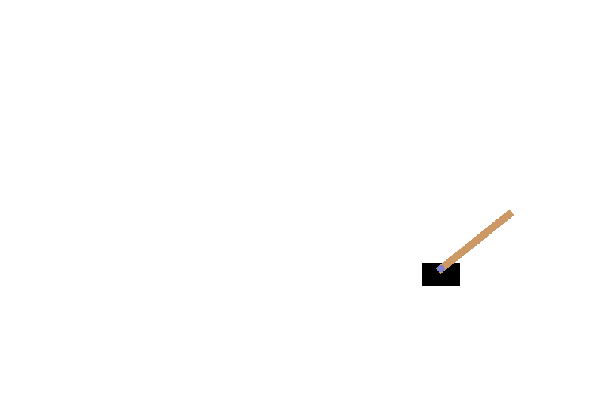
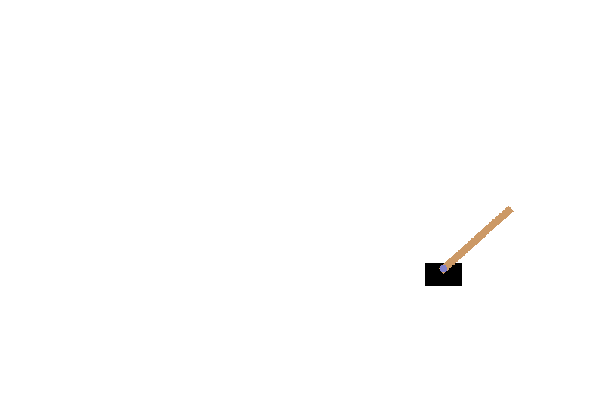
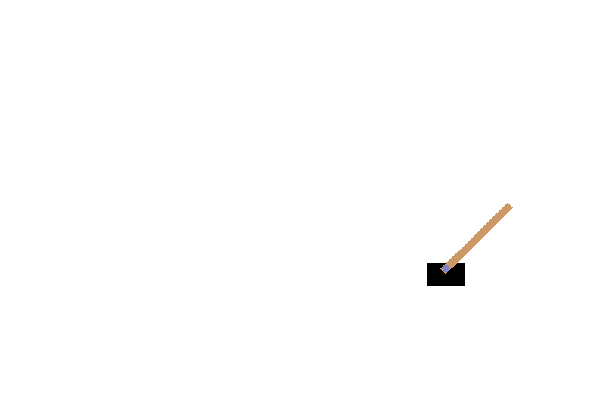
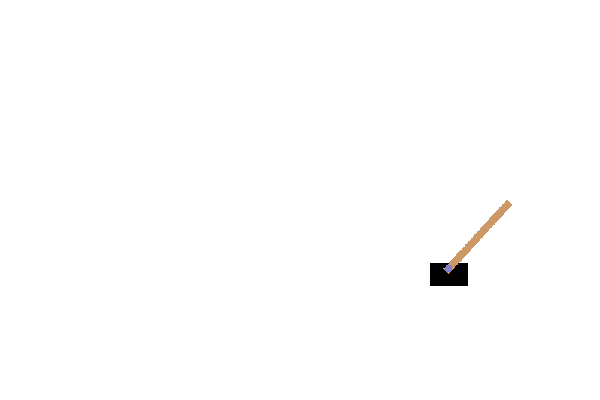
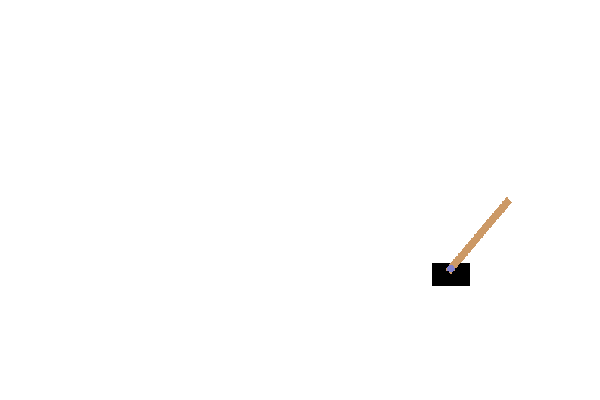
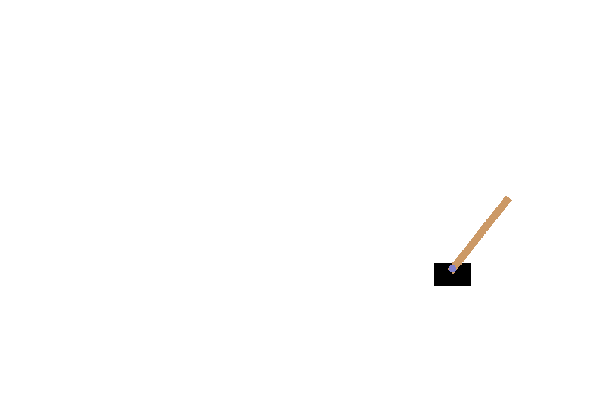
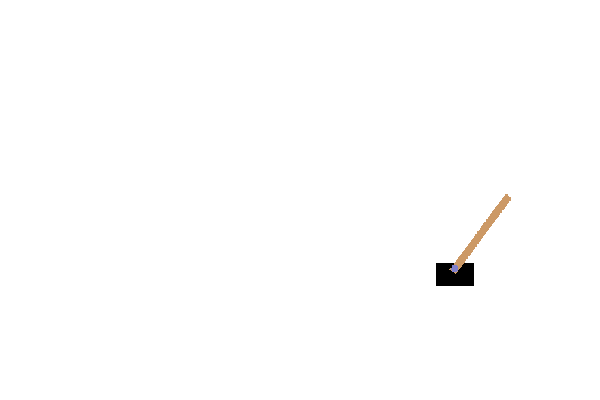
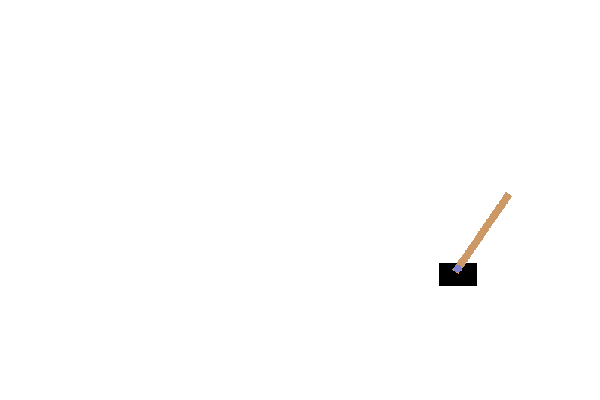
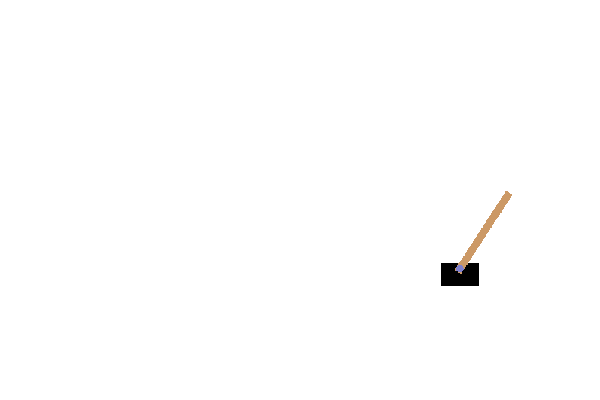
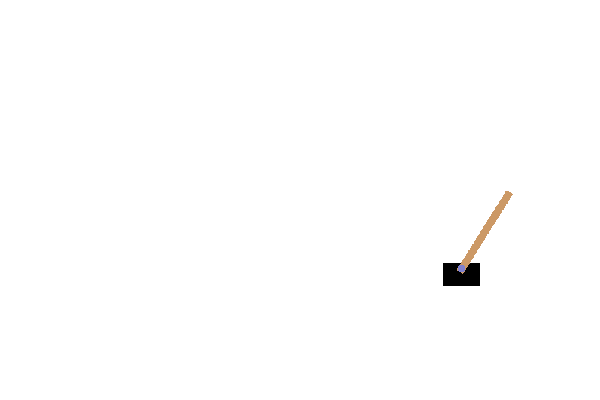
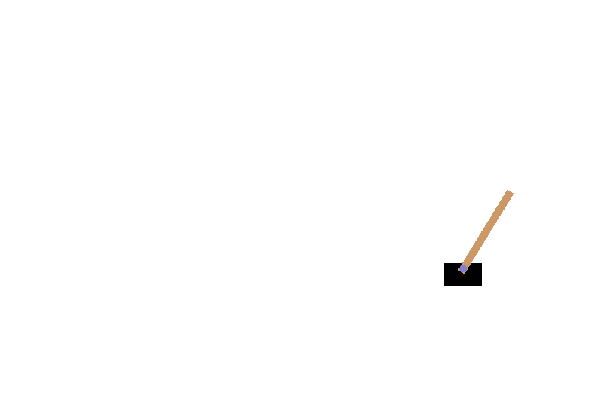
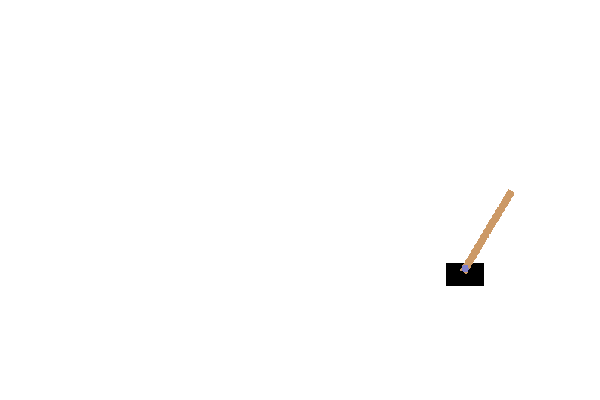
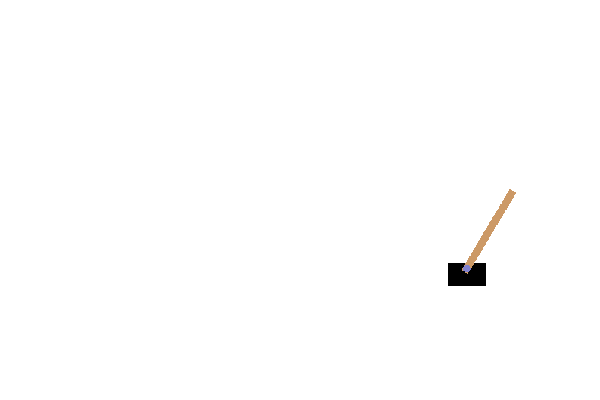
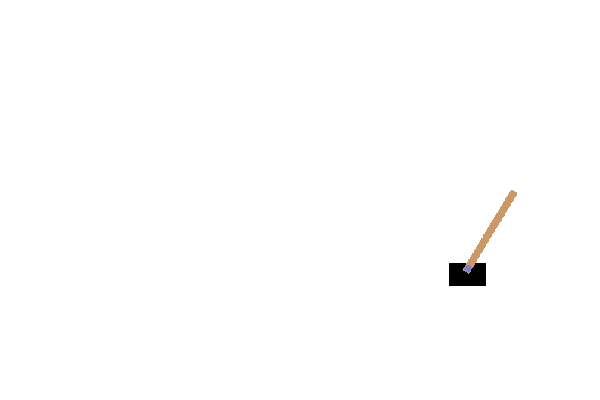
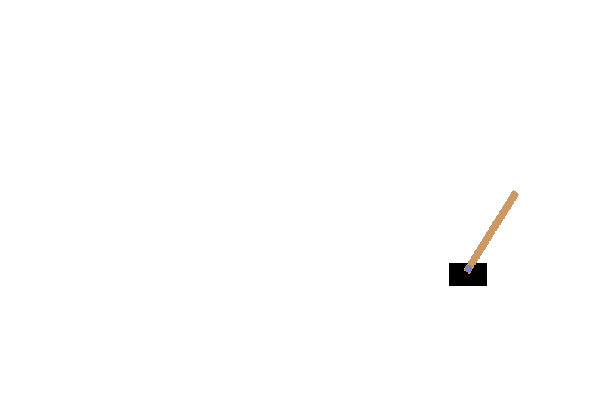
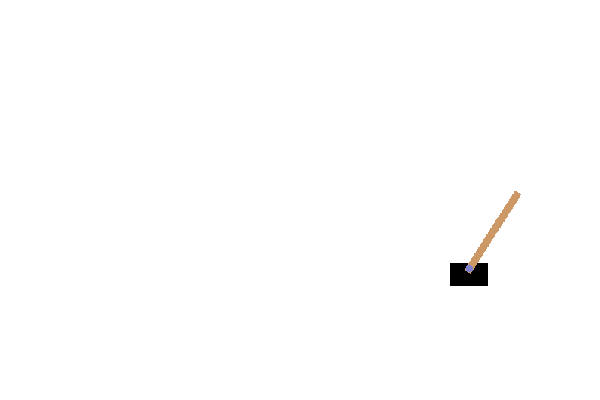
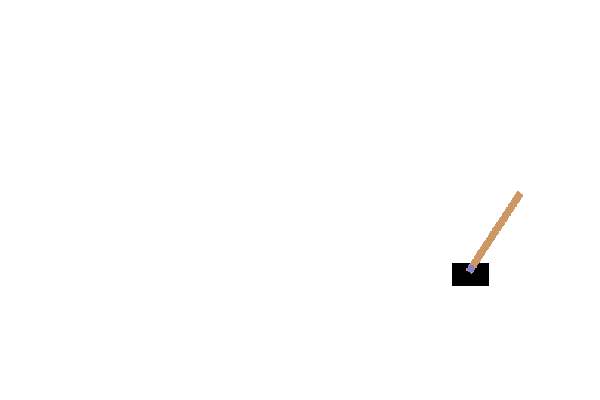
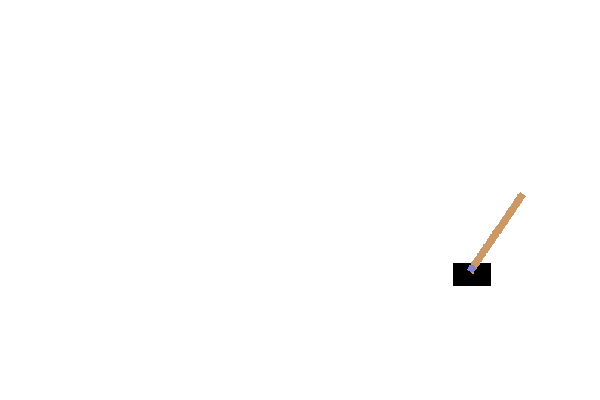
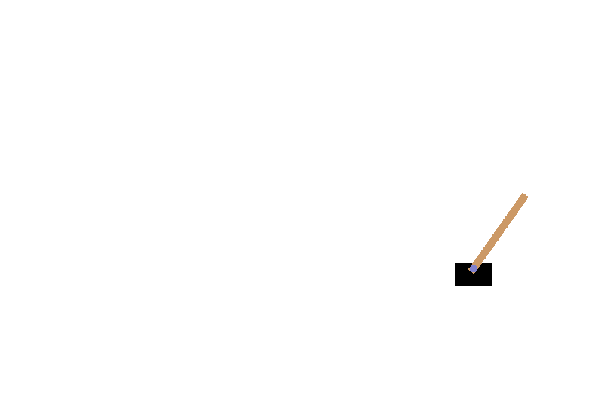
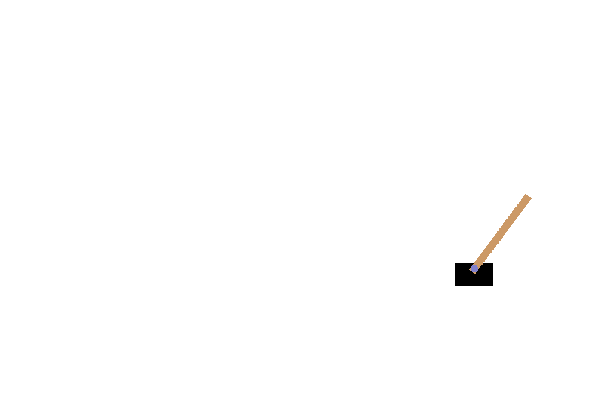
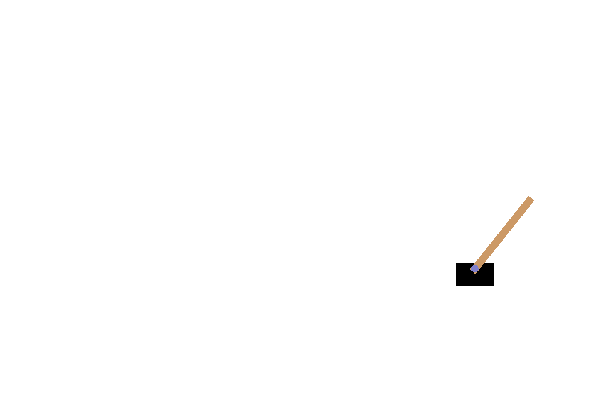
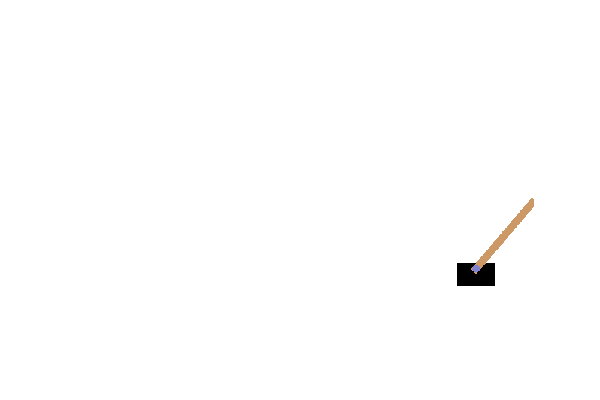
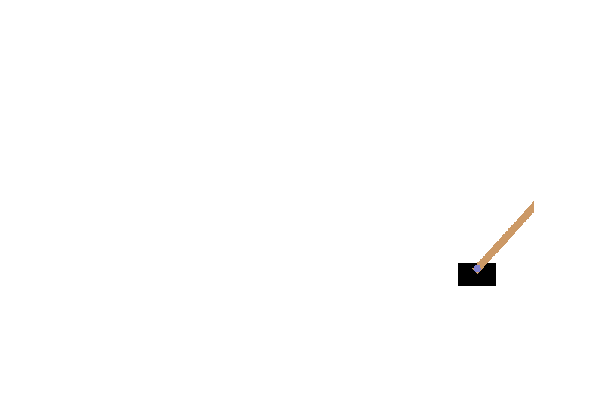
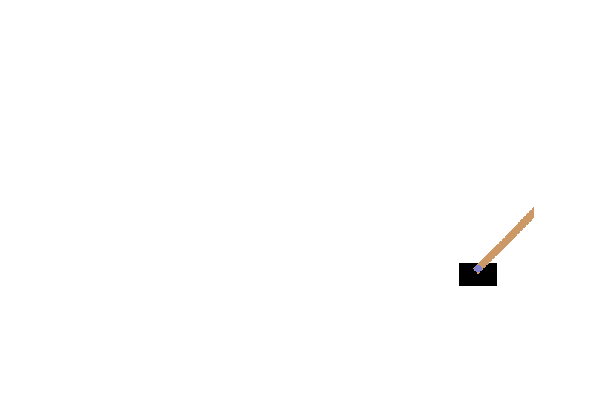
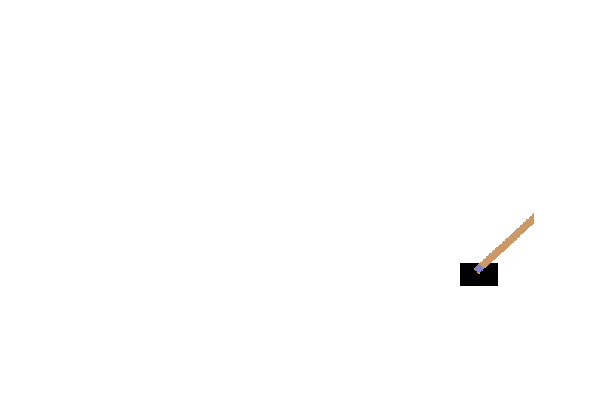
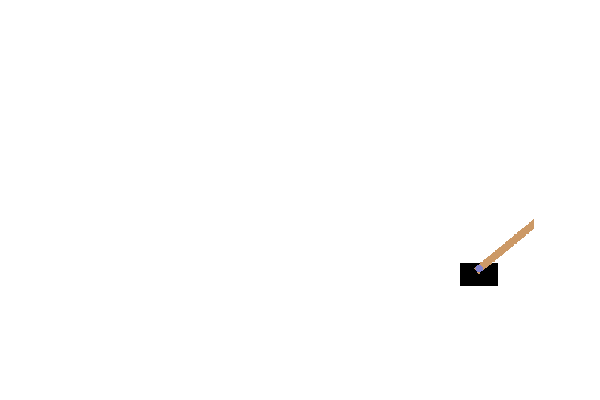
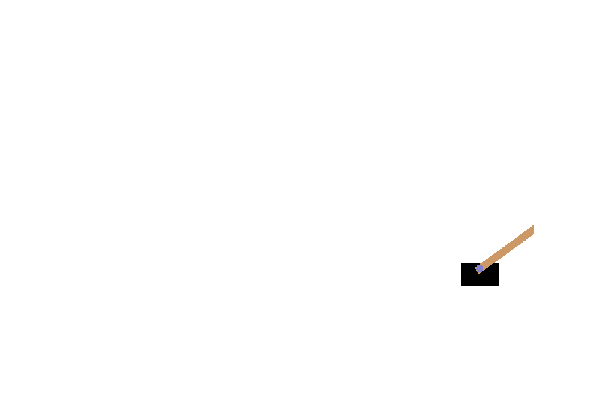
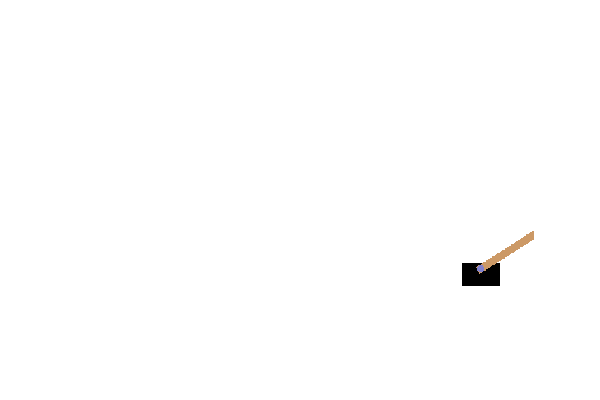
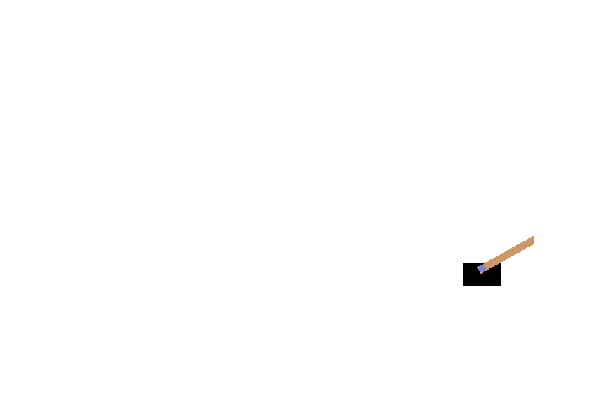
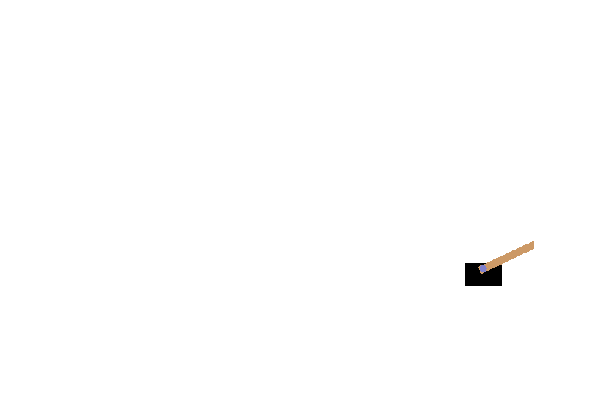
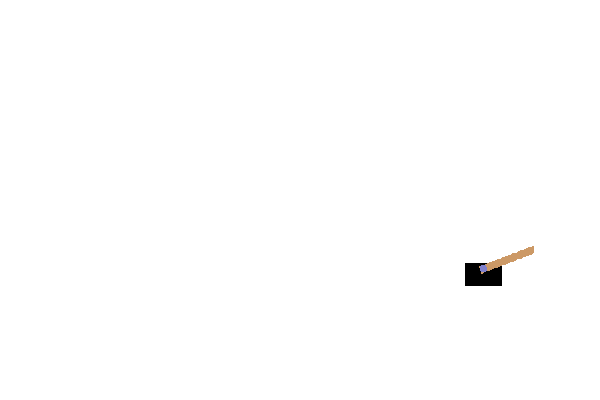
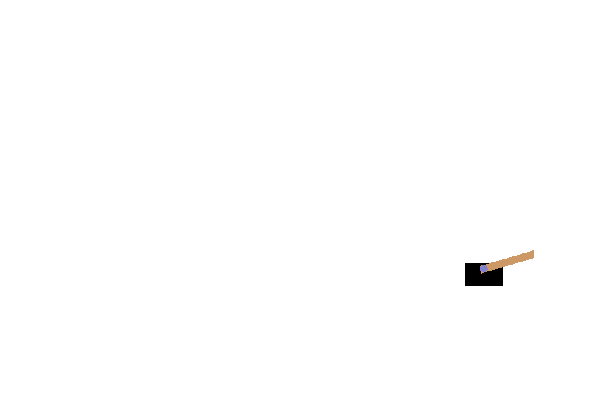
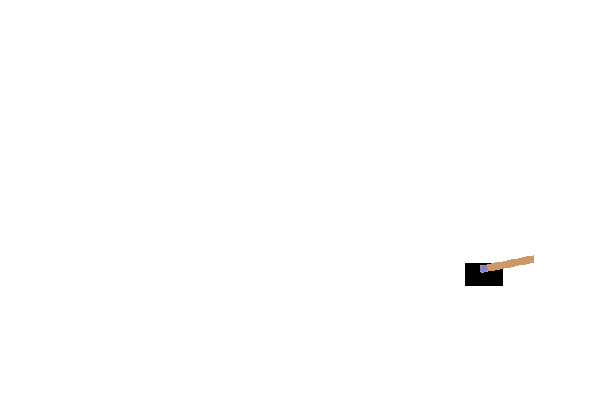
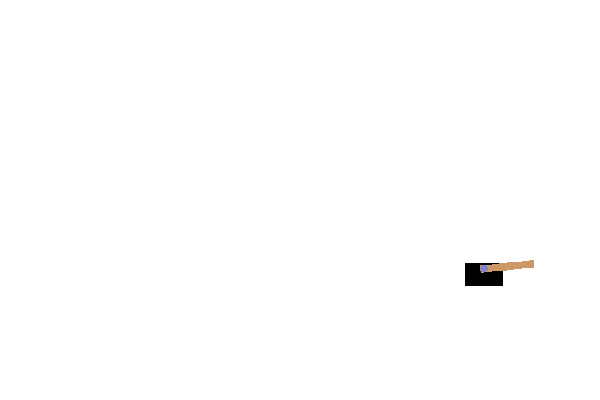
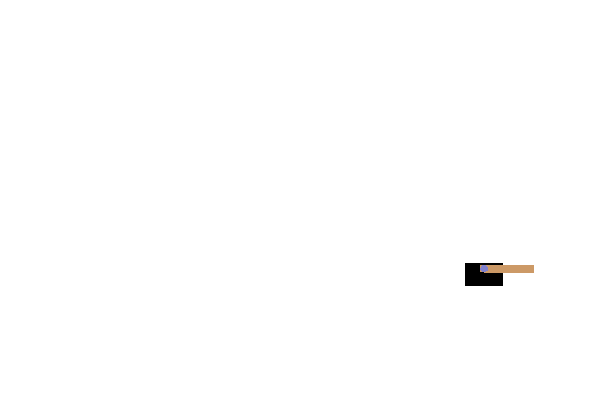
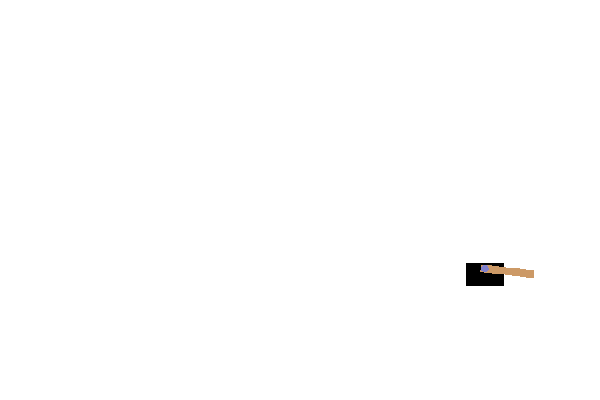
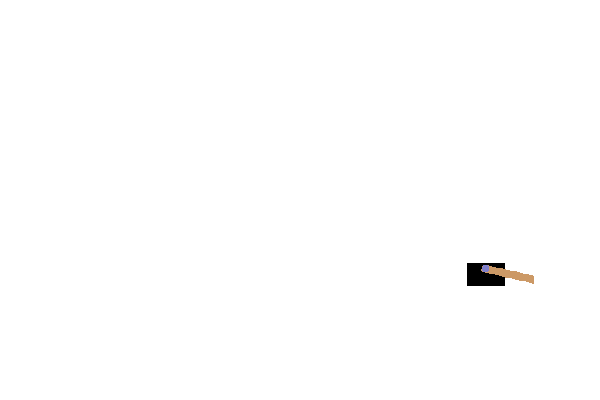
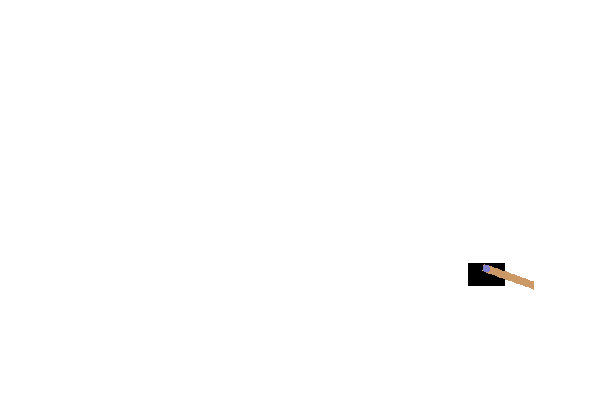
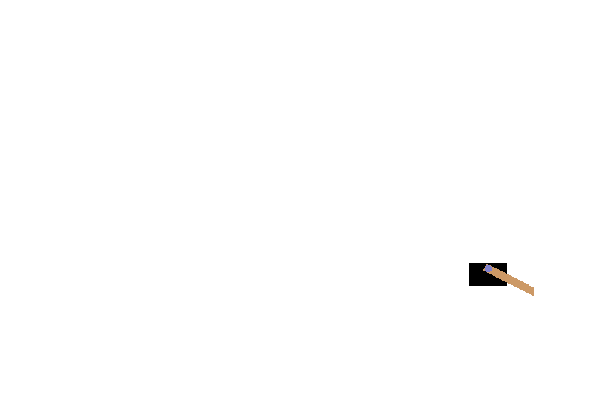
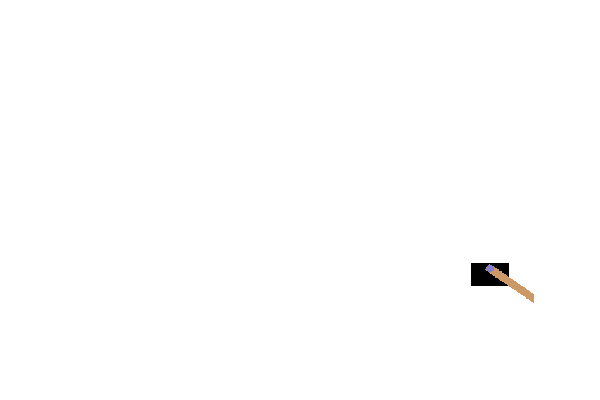
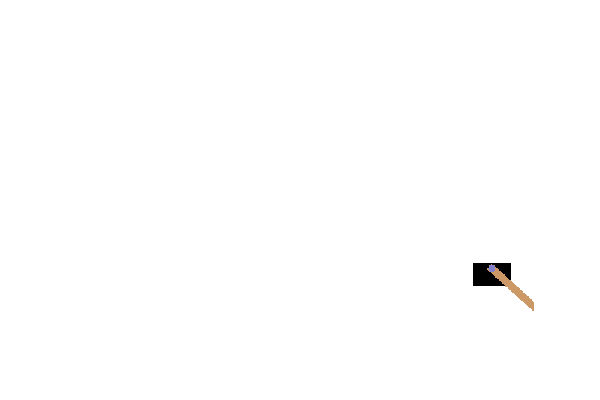
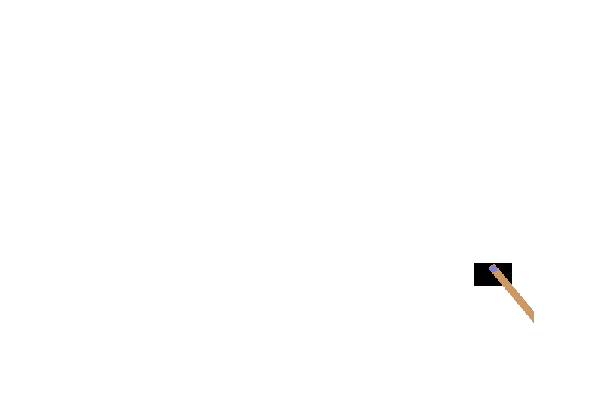
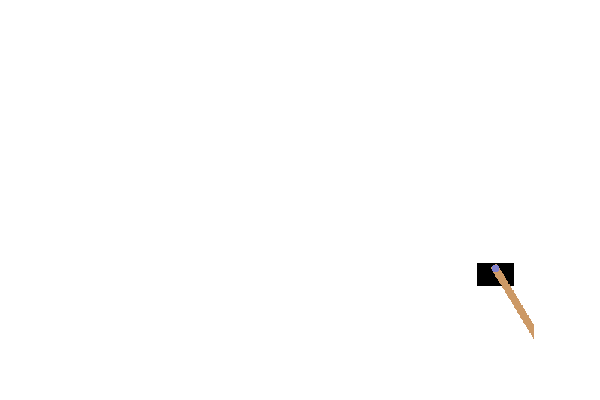
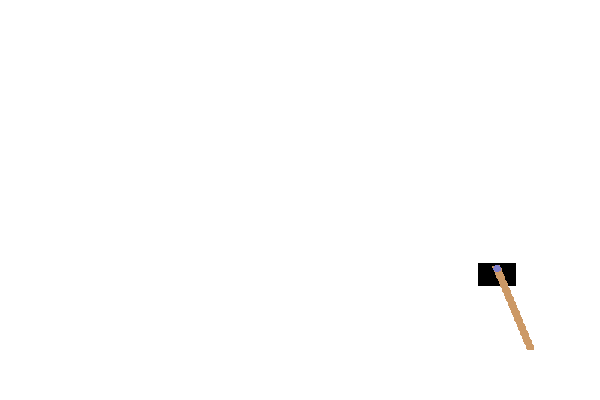
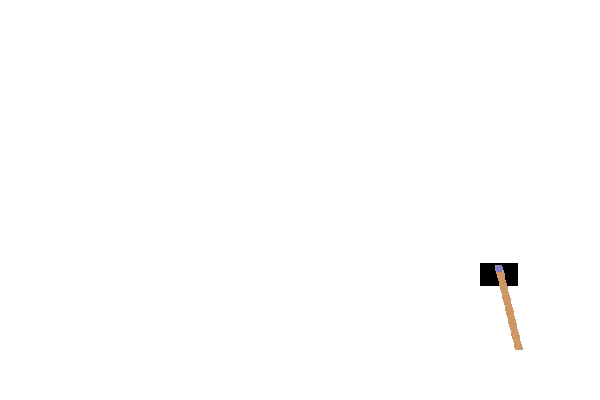
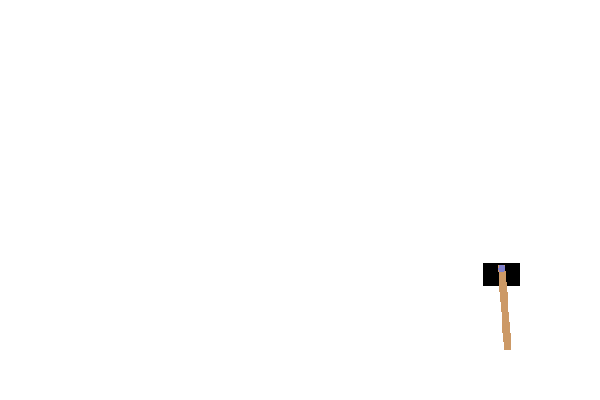
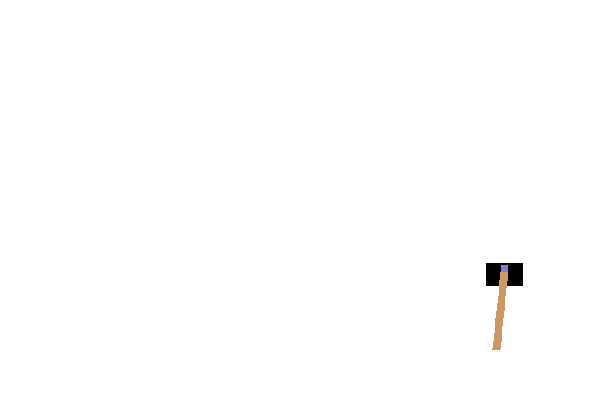
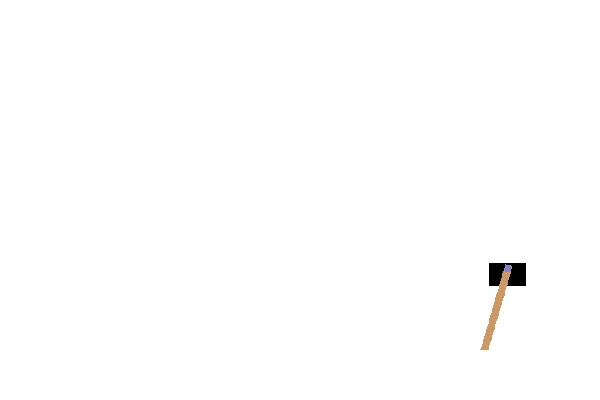
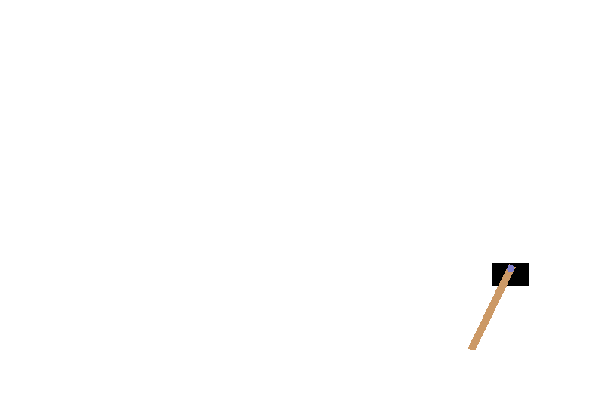
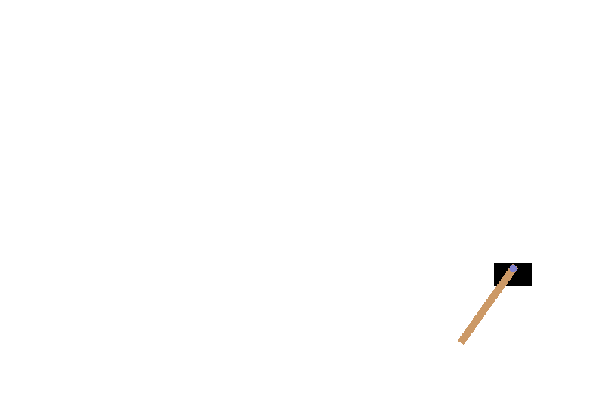
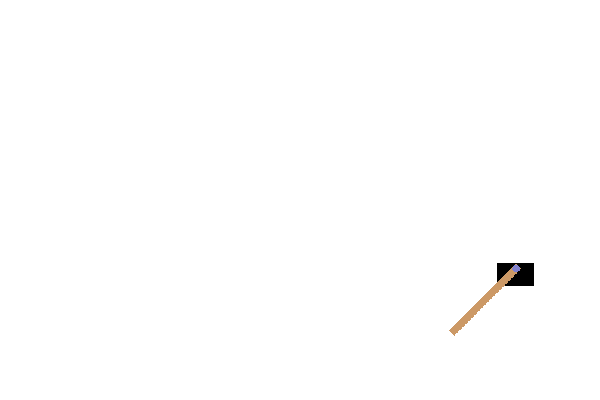
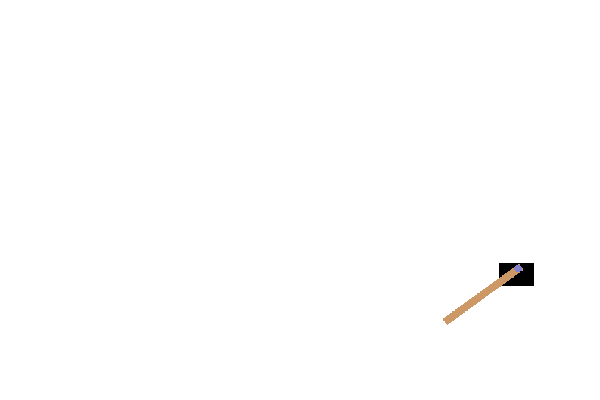
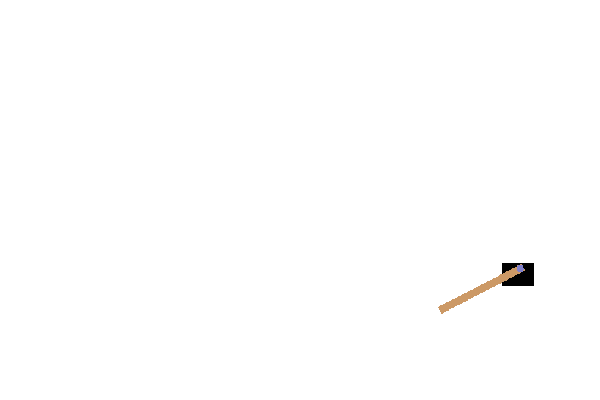
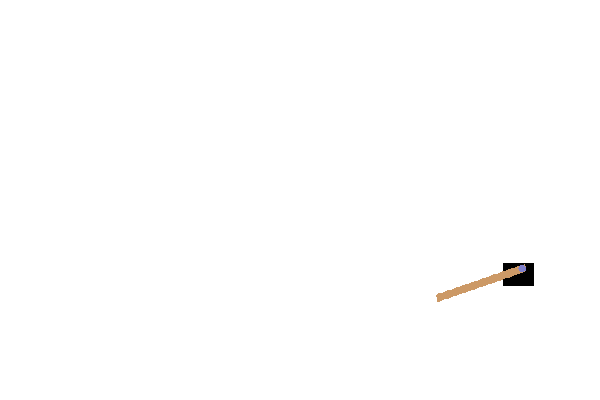
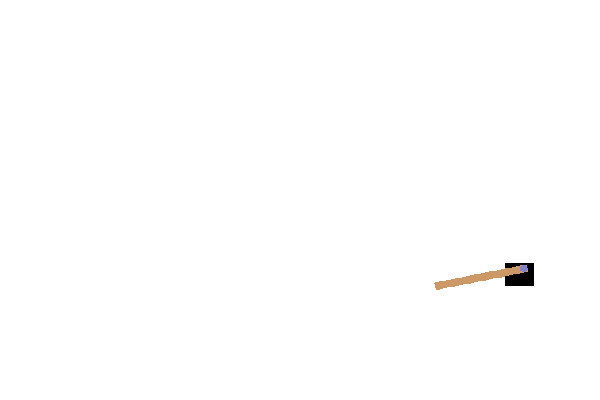
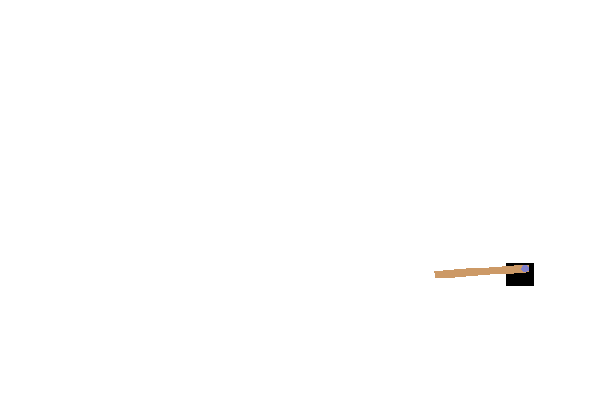
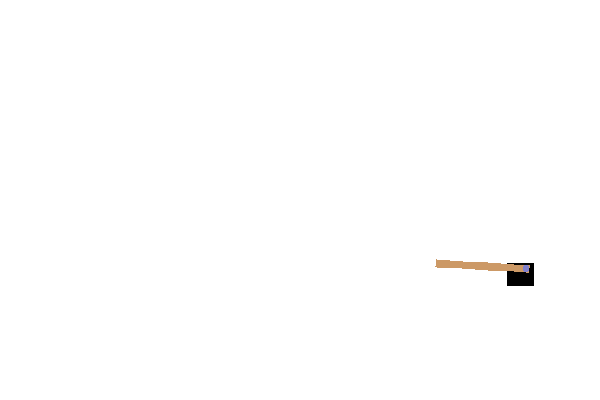
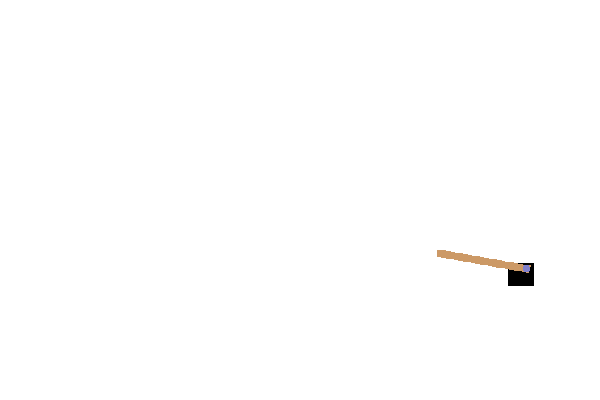
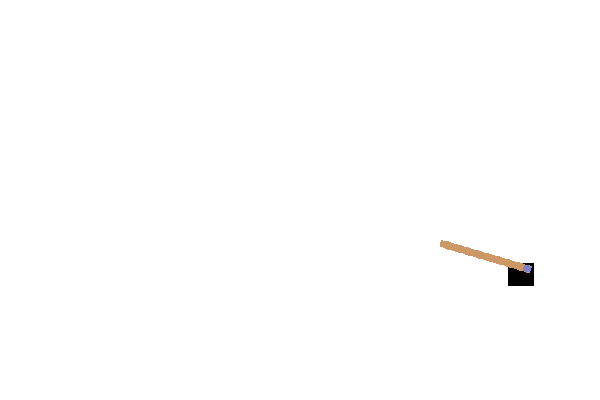
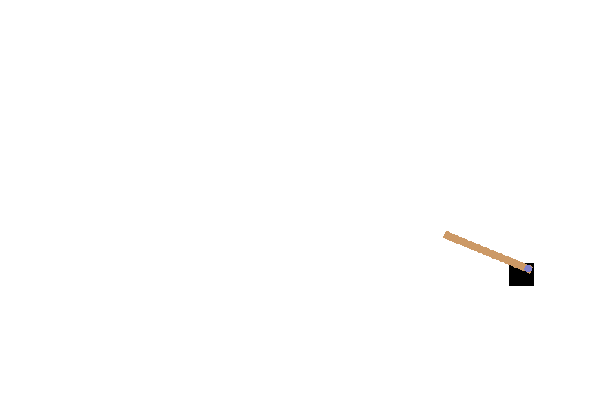
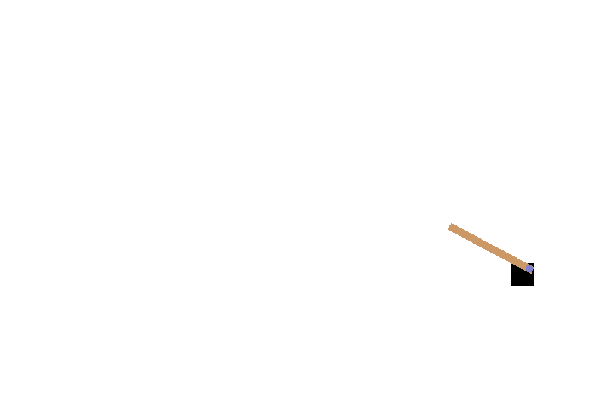
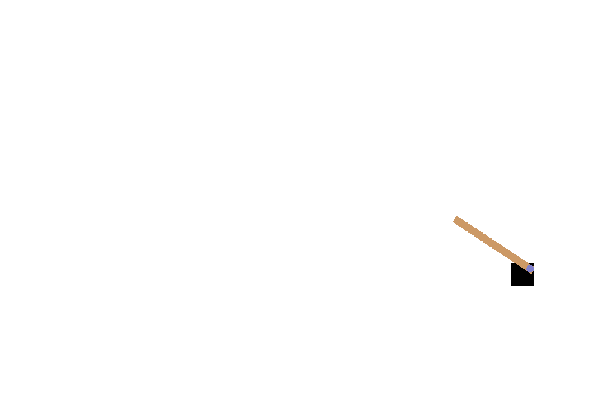
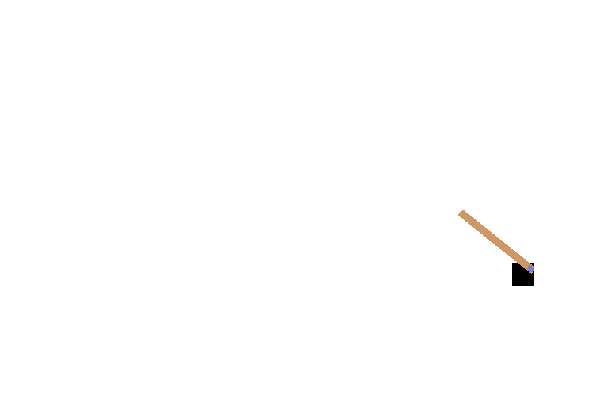
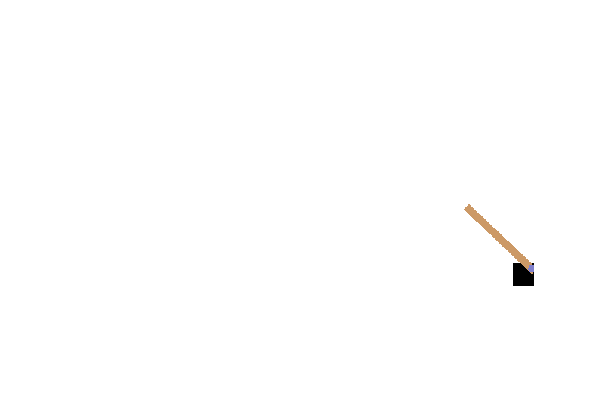
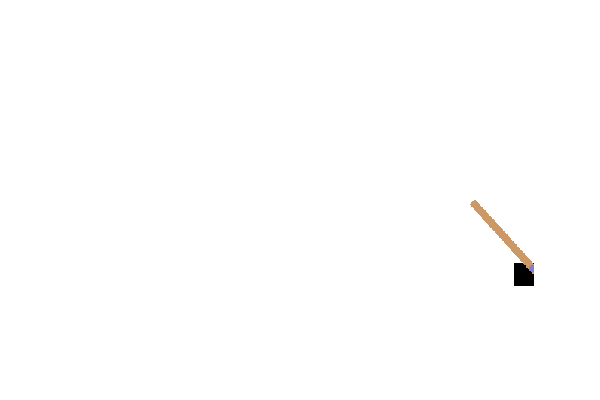
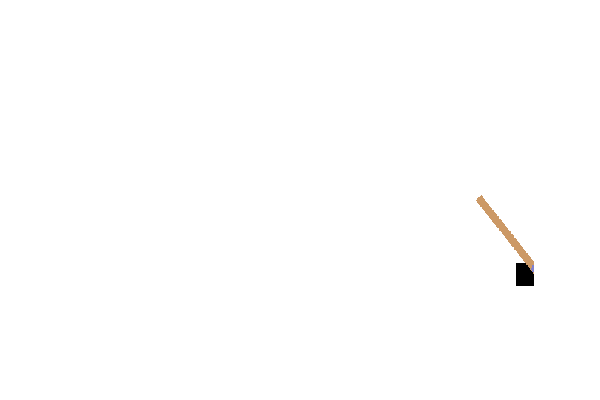
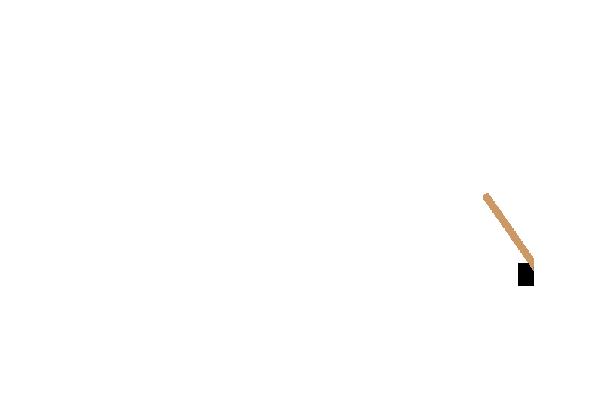
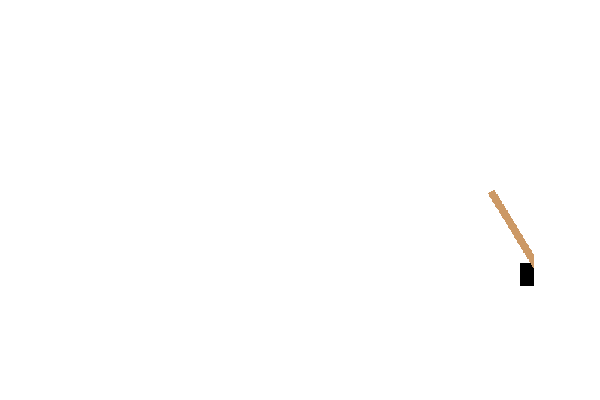
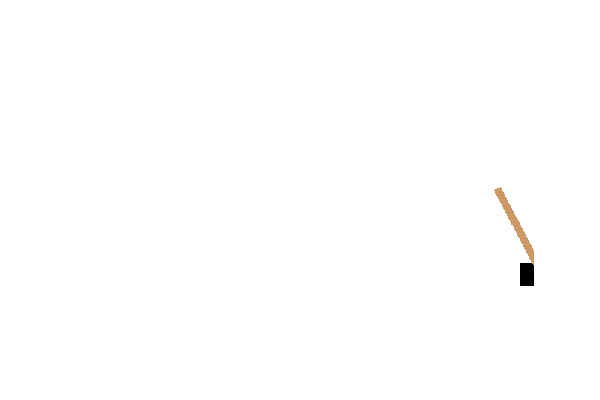
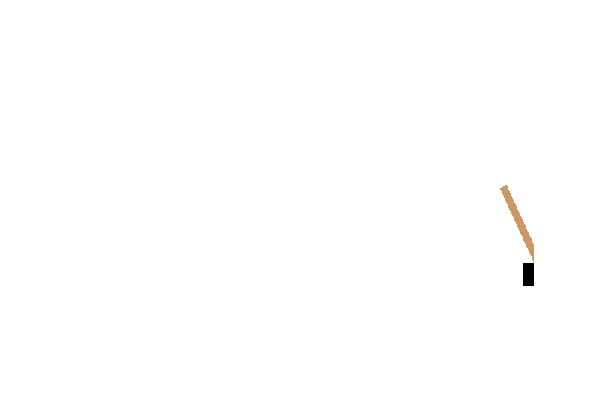
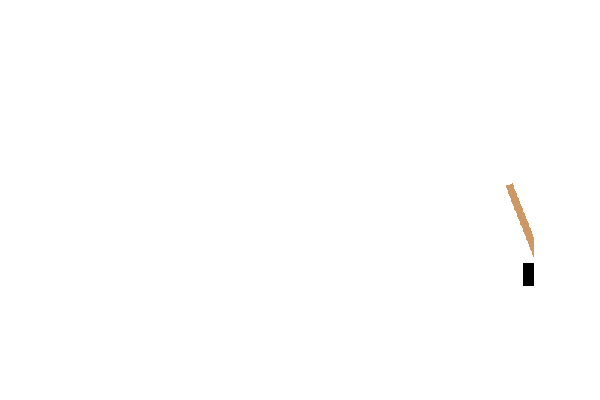
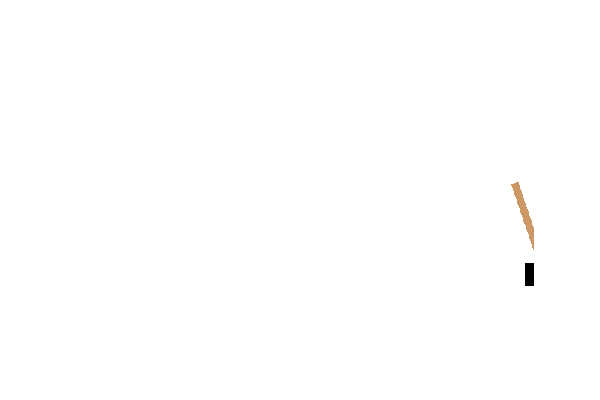
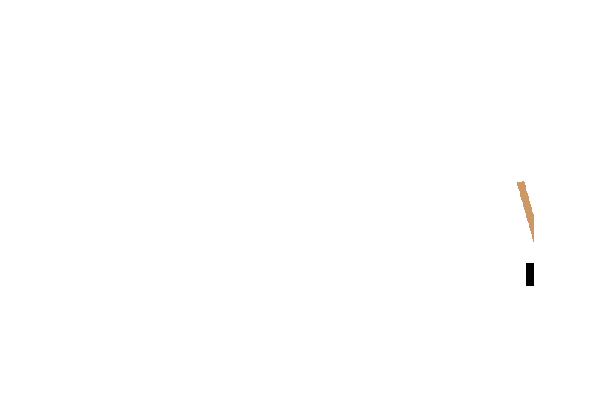
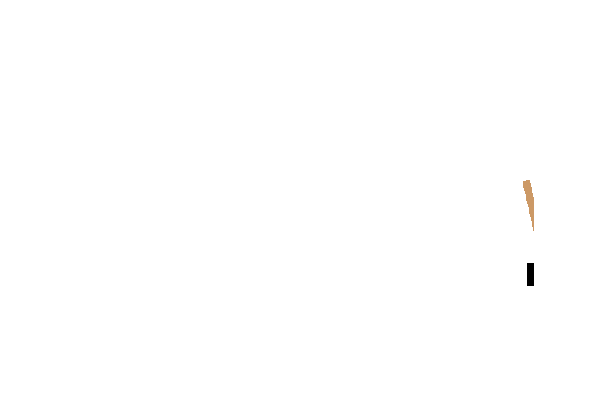
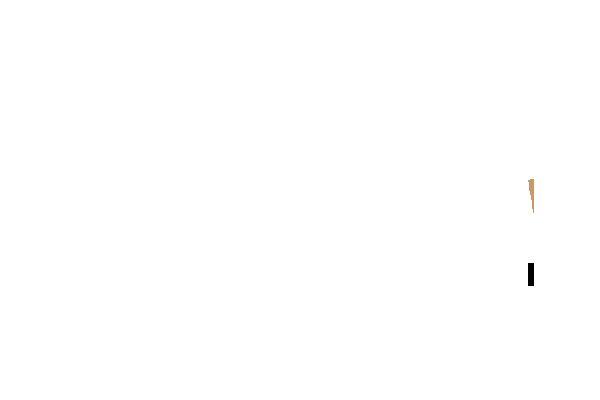
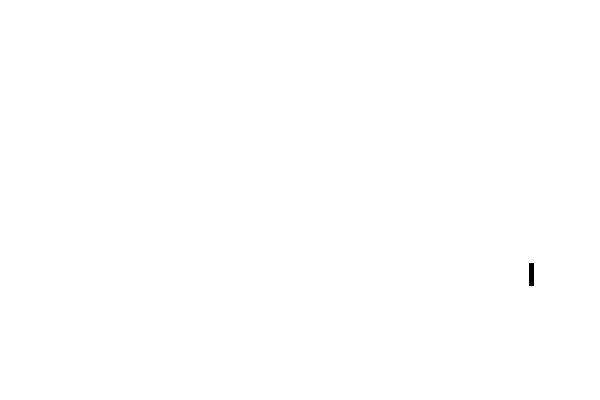
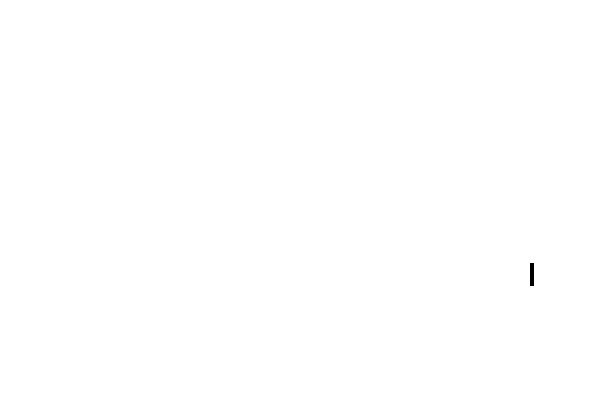
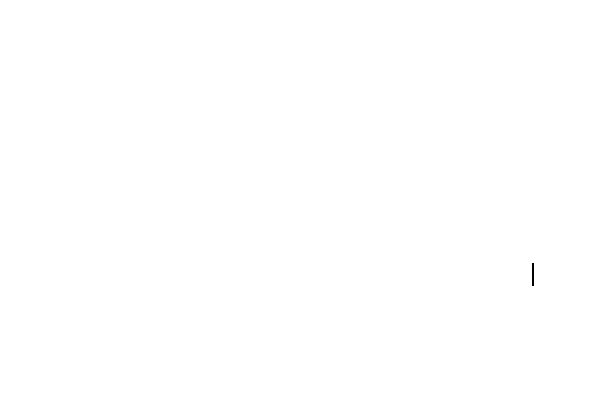
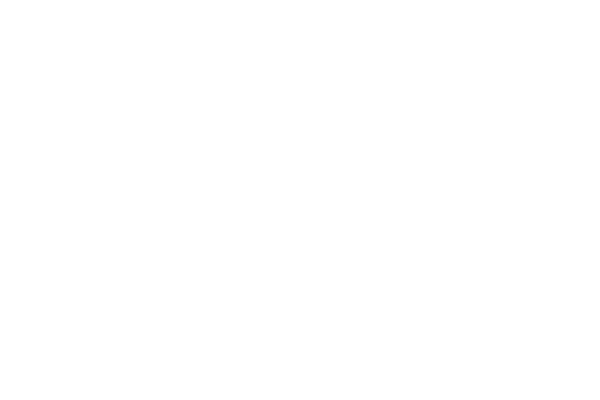
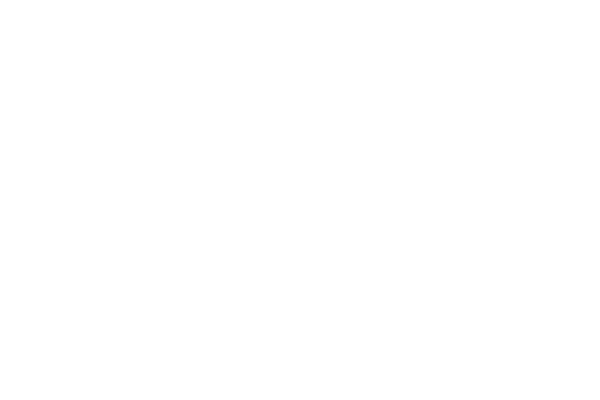
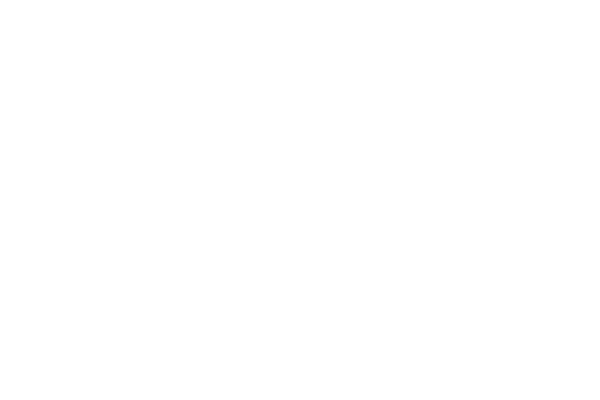
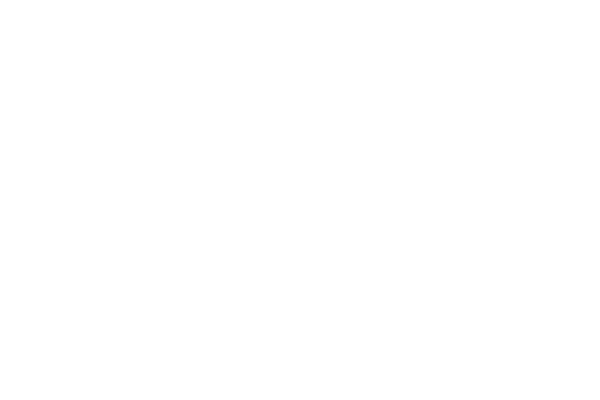
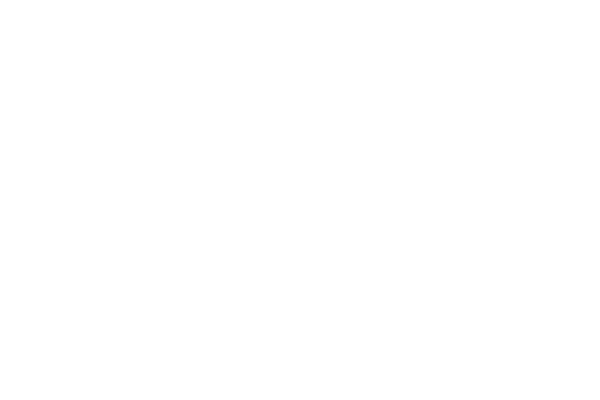
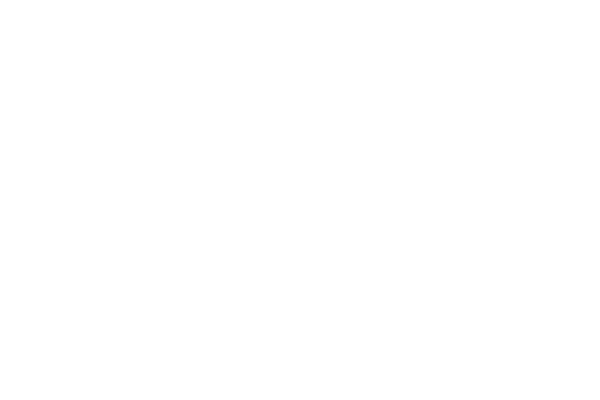
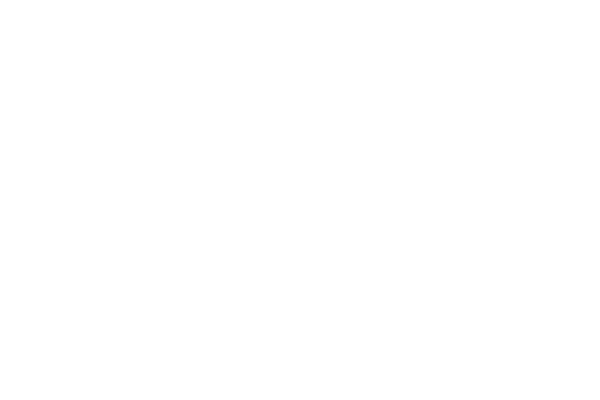
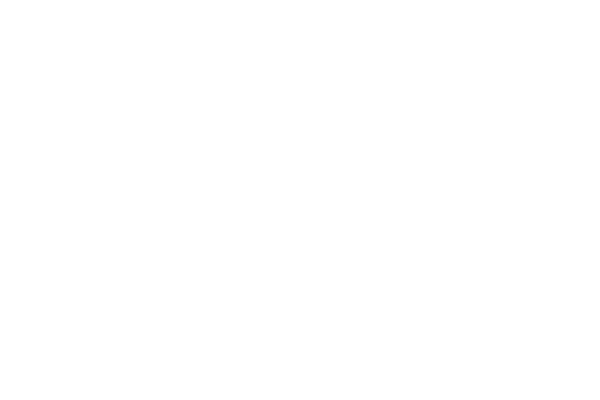
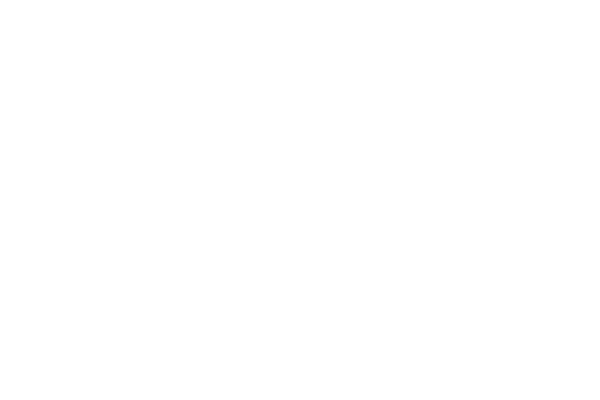
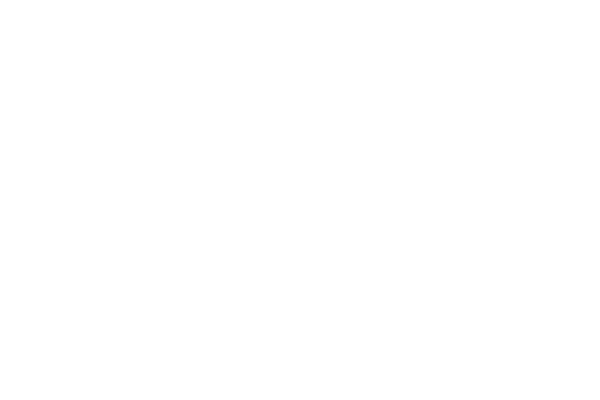
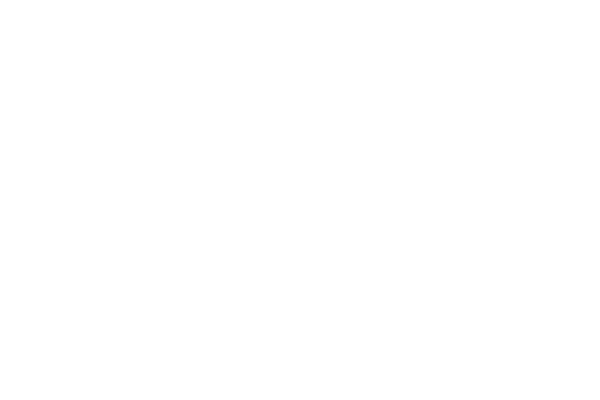
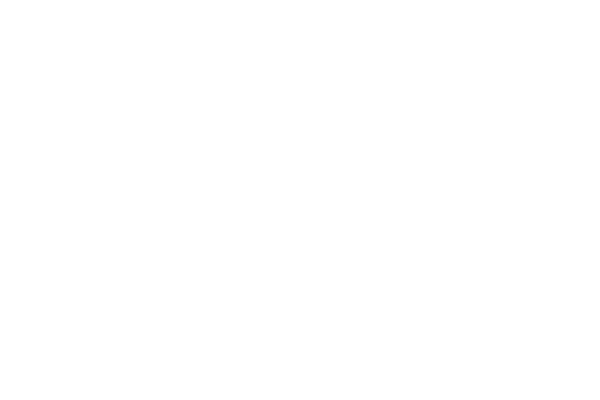
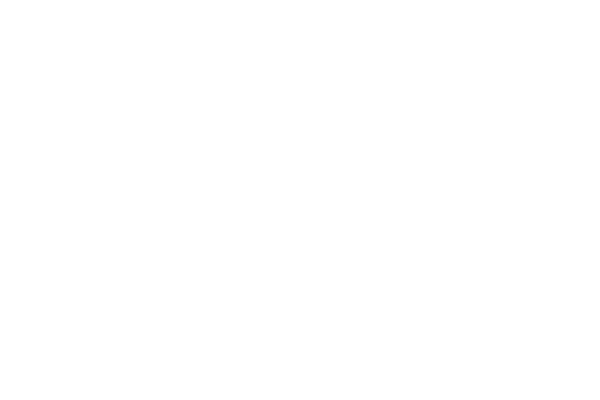
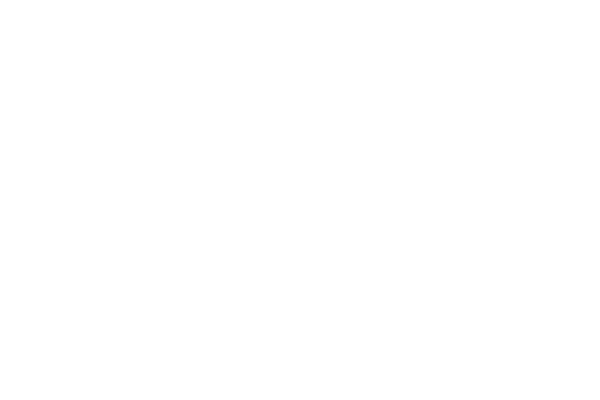
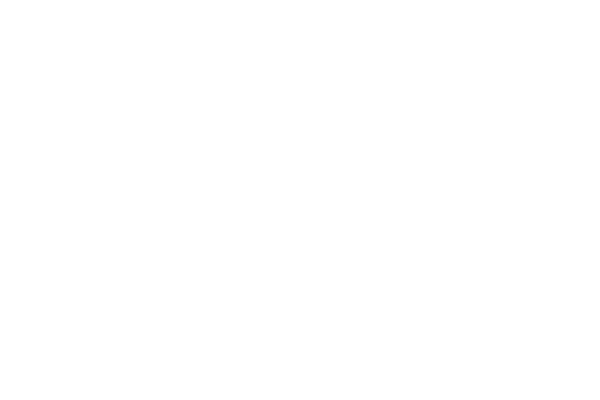
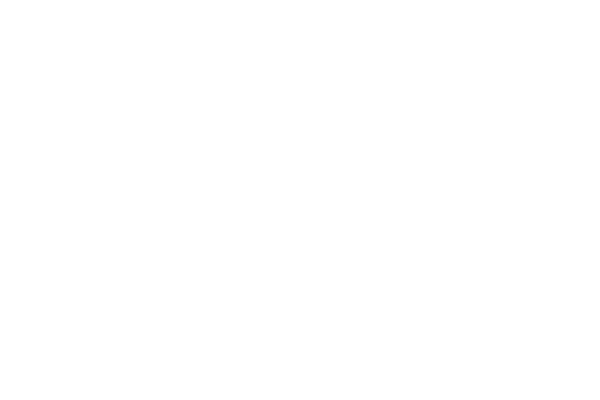
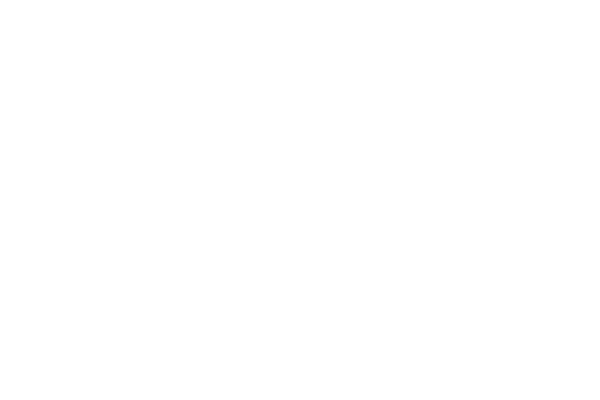
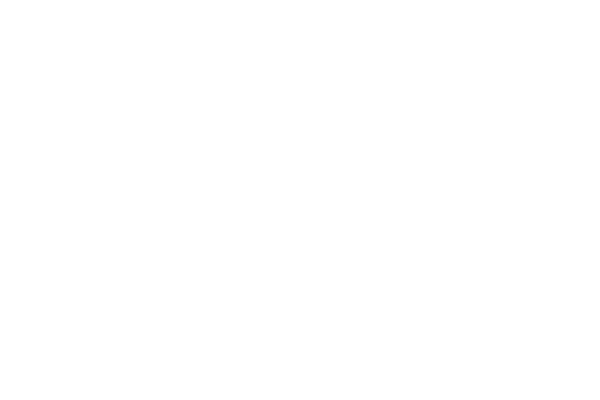
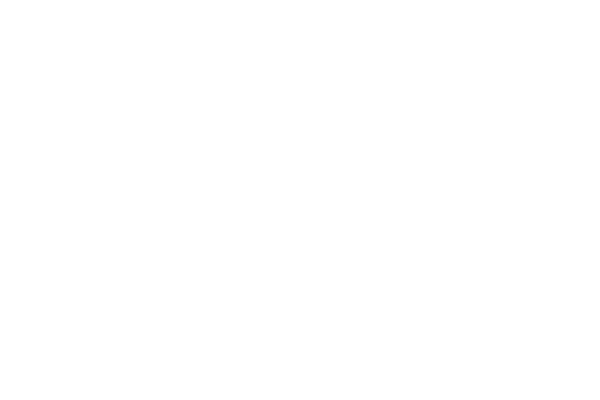
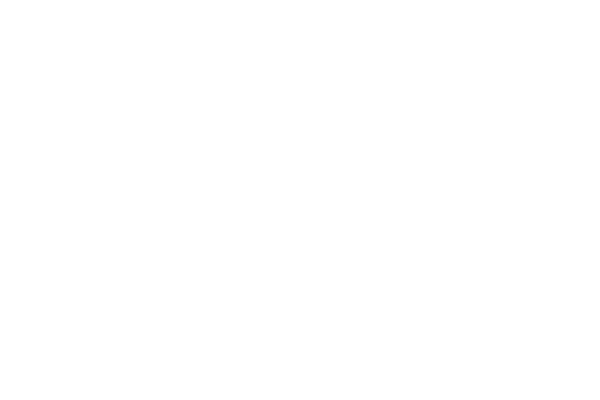
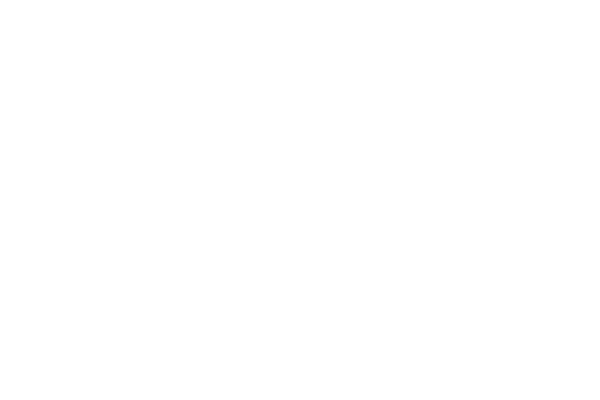
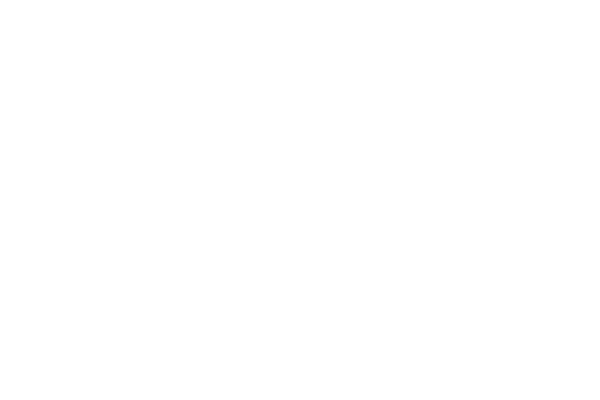
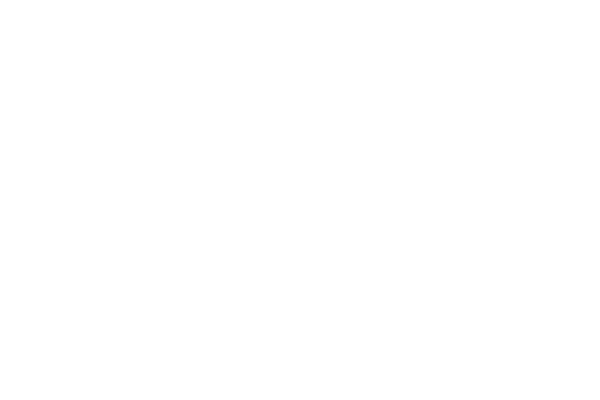
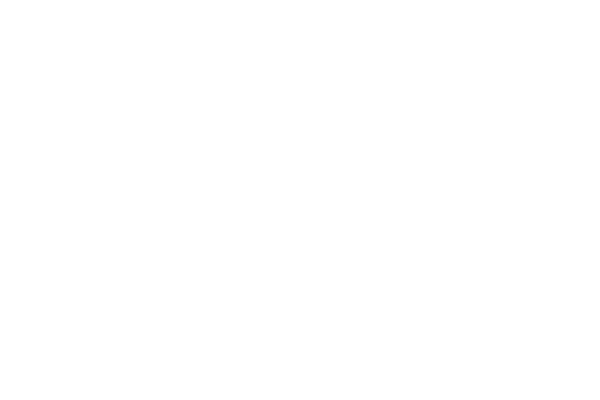
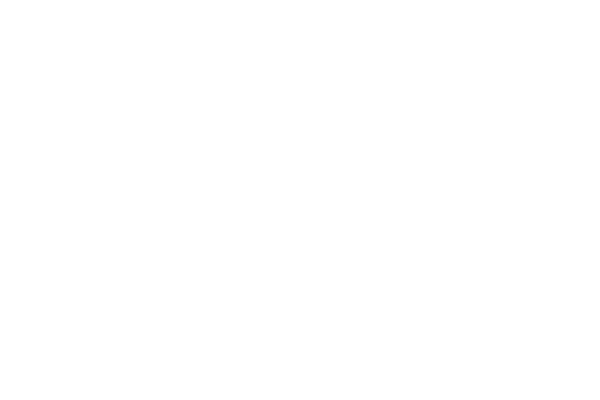
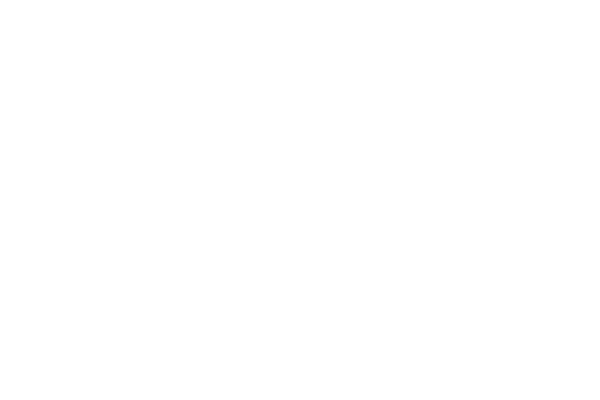
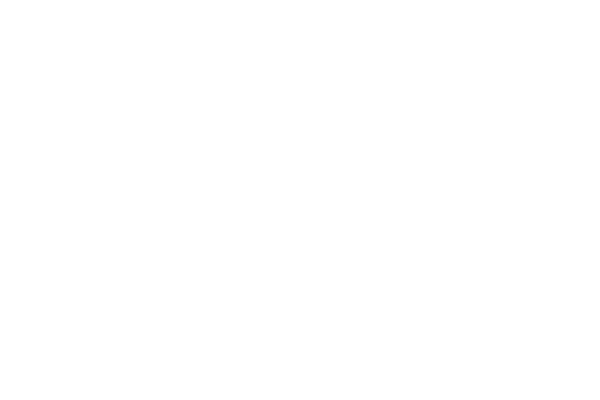
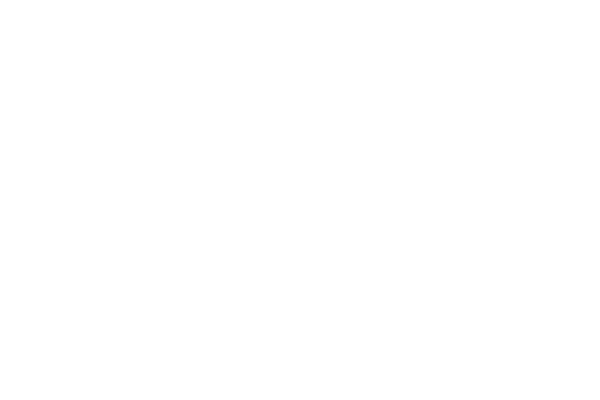
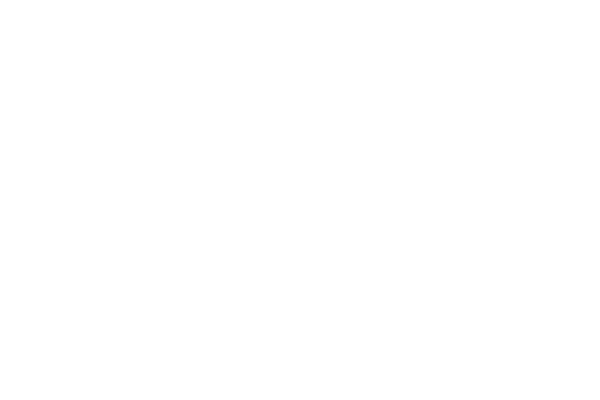
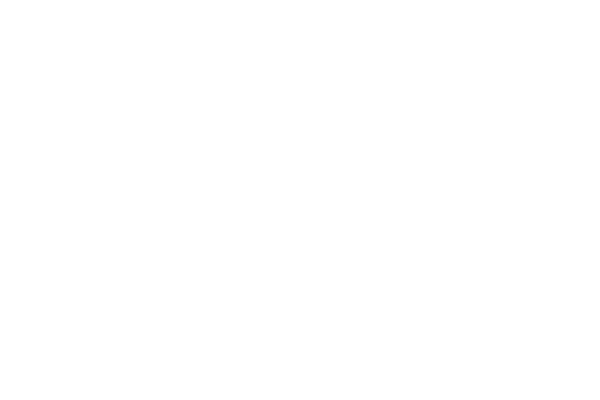
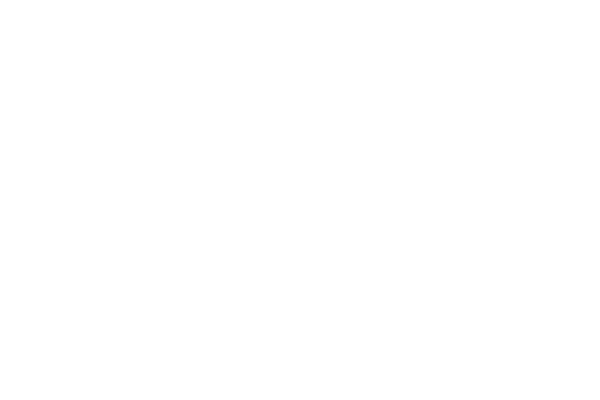
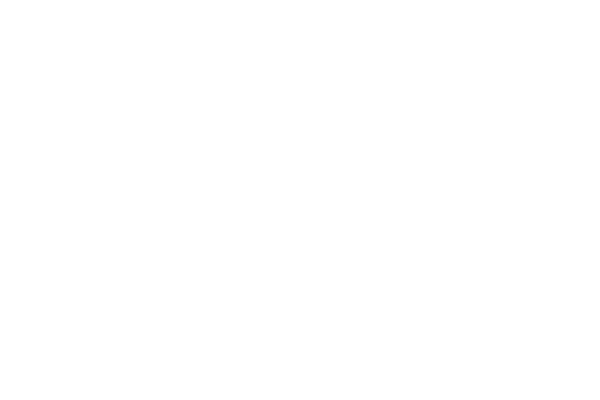
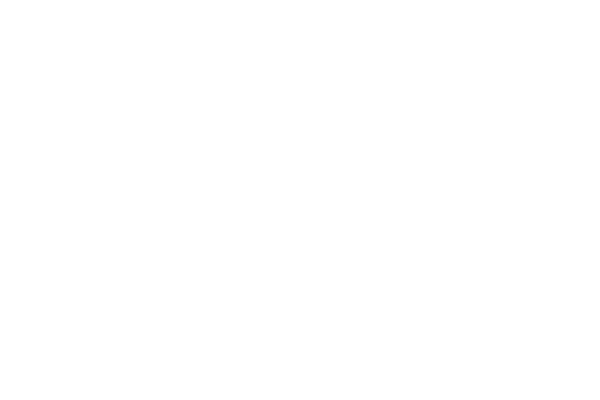
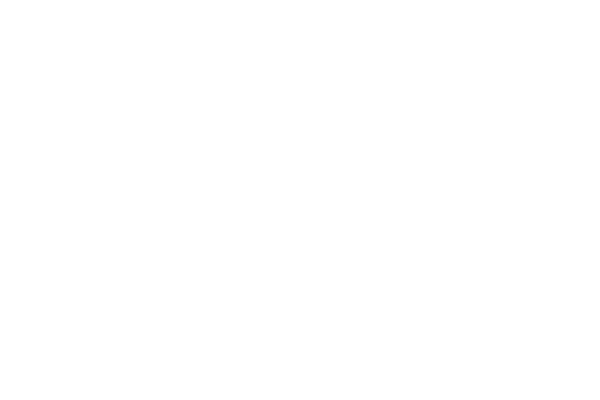
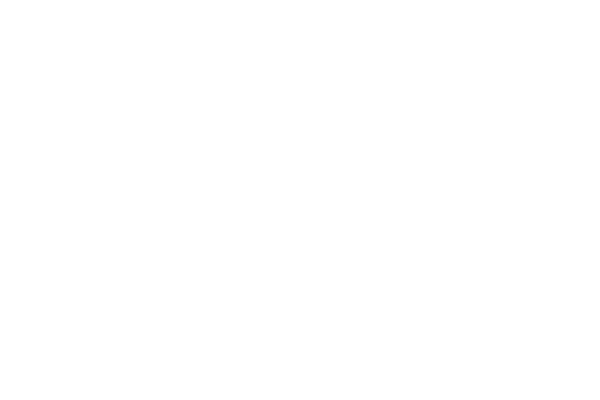
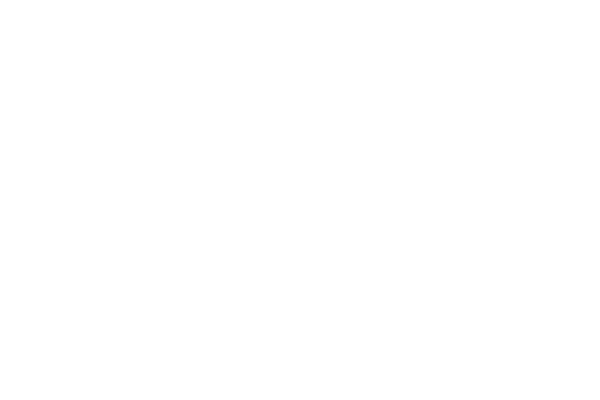
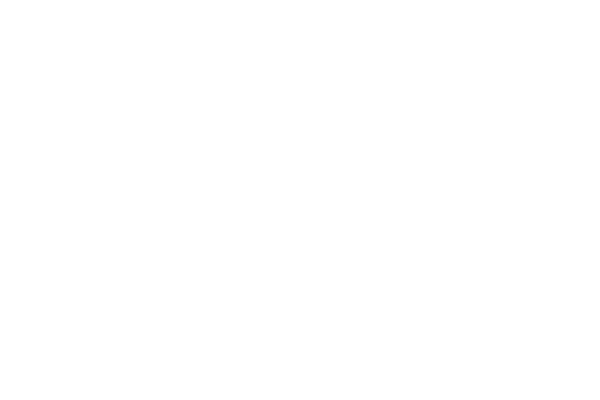
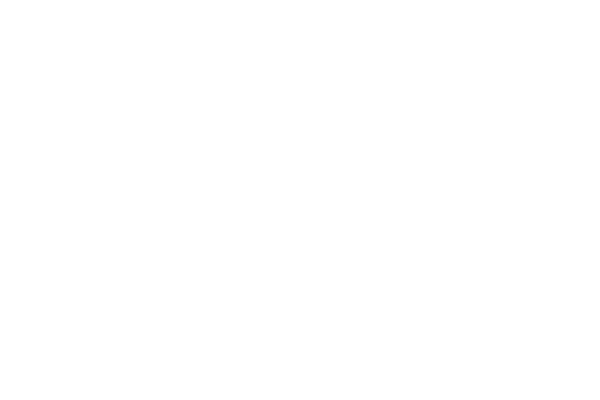
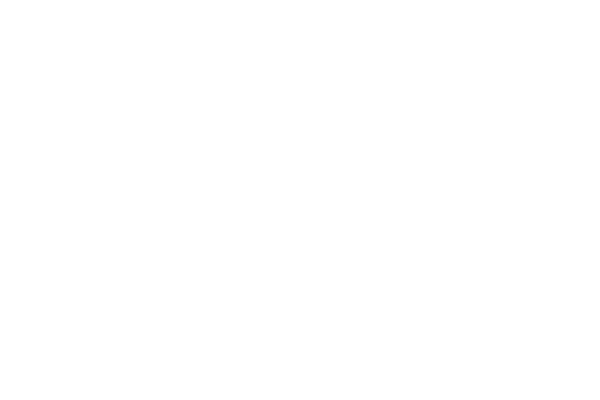
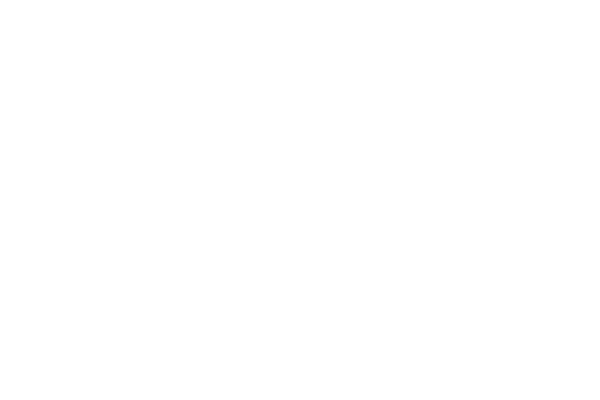
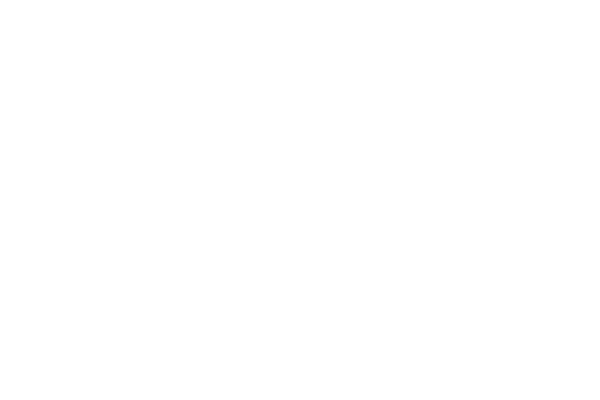
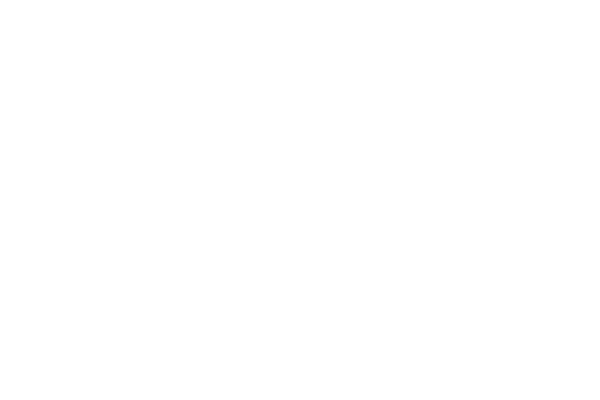
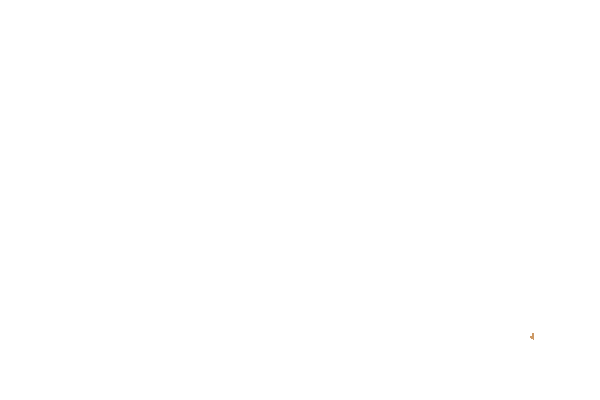
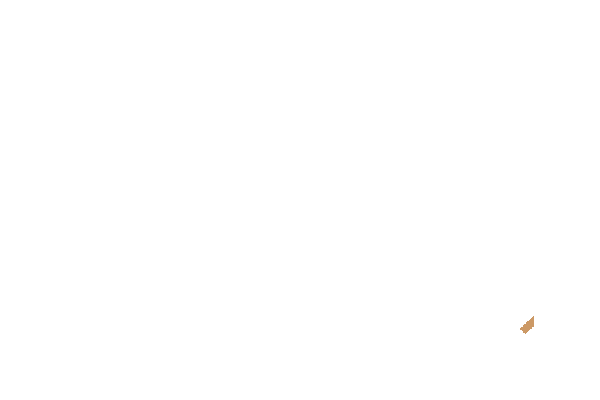
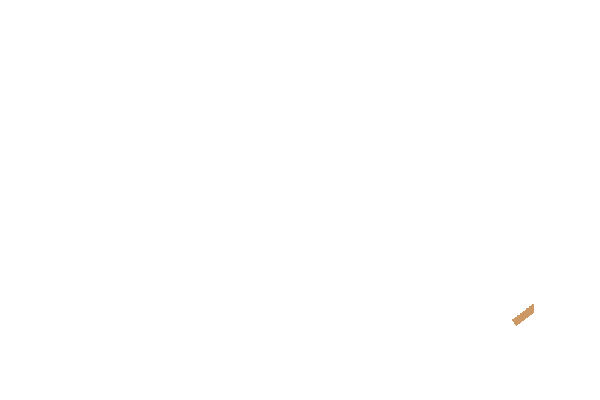
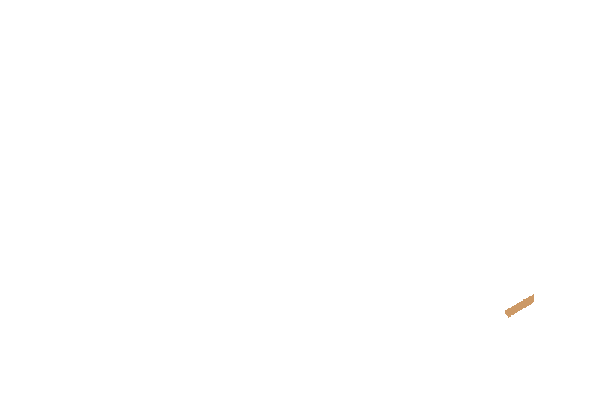
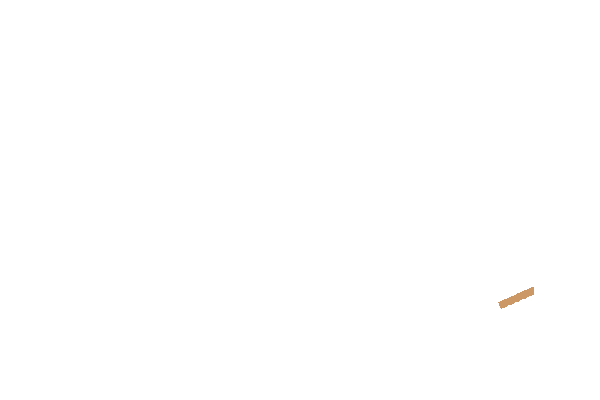
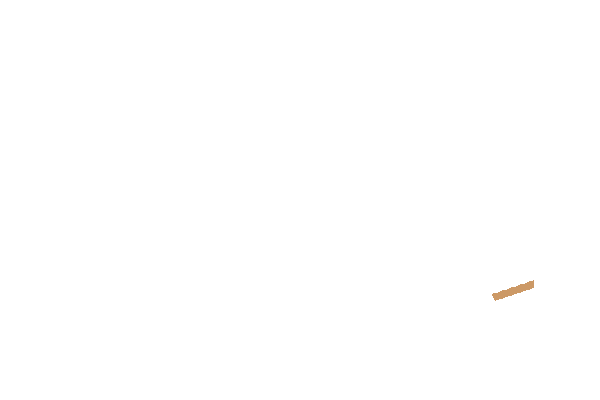
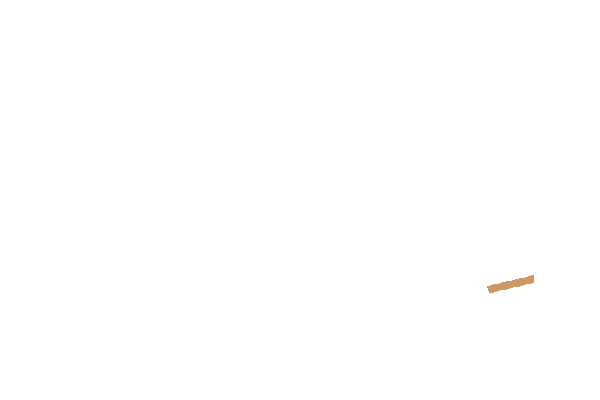
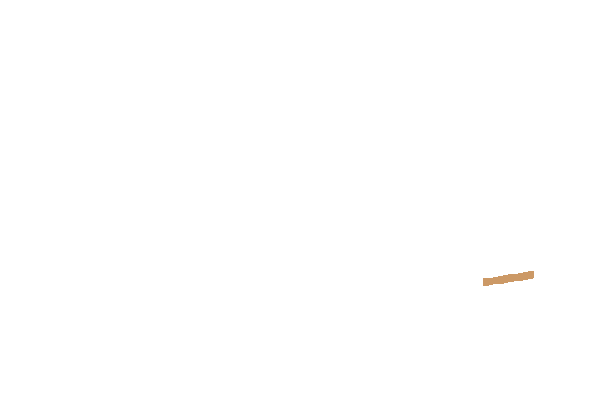
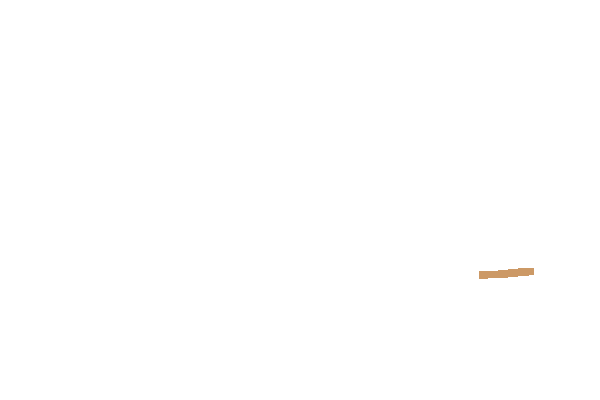
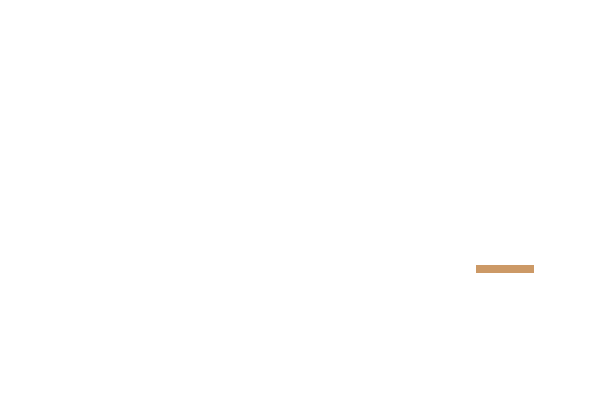
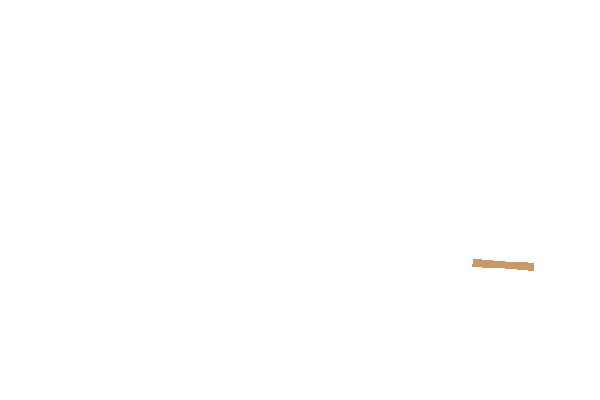

In [7]:
display_frames_as_gif(frames)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
ENV='CartPole-v0'
NUM_DIZITIZED=6
env=gym.make(ENV)
observation=env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
def bins(clip_min,clip_max,num):
    return np.linspace(clip_min,clip_max,num+1)[1:-1]

In [10]:
def digitize_state(observation):
    cart_pos,cart_v,pole_angle,pole_v=observation
    digitized=[
        np.digitize(cart_pos,bins=bins(-2.4,2.4,NUM_DIZITIZED)),
        np.digitize(cart_pos,bins=bins(-3.0,3.0,NUM_DIZITIZED)),
        np.digitize(cart_pos,bins=bins(-0.5,0.5,NUM_DIZITIZED)),
        np.digitize(cart_pos,bins=bins(-2.0,2.0,NUM_DIZITIZED))]
    return sum([x*(NUM_DIZITIZED**i) for i,x in enumerate(digitized)])

In [11]:
digitize_state(observation)

777

In [12]:
ENV='CartPole-v0'
NUM_DIZITIZED=6
GAMMA=0.99
ETA=0.5
MAX_STEPS=200
NUM_EPISODES=1000

In [13]:
class Agent:
    def __init__(self,num_states,num_actions):
        self.brain=Brain(num_states,num_actions)
    
    def update_Q_function(self,observation,action,reward,observation_next):
        self.brain.update_Q_table(observation,action,reward,observation_next)
        
    def get_action(self,observation,step):
        action=self.brain.decide_action(observation,step)
        return action

In [14]:
class Brain:
    def __init__(self,num_states,num_actions):
        self.num_actions=num_actions
        self.q_table=np.random.uniform(low=0,high=1,size=(NUM_DIZITIZED**num_states,num_actions))
    
    def bins(self,clip_min,clip_max,num):
        return np.linspace(clip_min,clip_max,num+1)[1:-1]
        
    def digitize_state(self,observation):
        cart_pos,cart_v,pole_angle,pole_v=observation
        digitized=[
            np.digitize(cart_pos,bins=bins(-2.4,2.4,NUM_DIZITIZED)),
            np.digitize(cart_pos,bins=bins(-3.0,3.0,NUM_DIZITIZED)),
            np.digitize(cart_pos,bins=bins(-0.5,0.5,NUM_DIZITIZED)),
            np.digitize(cart_pos,bins=bins(-2.0,2.0,NUM_DIZITIZED))]
        return sum([x*(NUM_DIZITIZED**i) for i,x in enumerate(digitized)])
    
    def update_Q_table(self,observation,action,reward,observation_next):
        state=self.digitize_state(observation)
        state_next=self.digitize_state(observation_next)
        Max_Q_next=max(self.q_table[state_next][:])
        self.q_table[state,action]=self.q_table[state,action]+ETA*(reward+GAMMA*Max_Q_next-self.q_table[state,action])
    
    def decide_action(self,observation,episode):
        state=self.digitize_state(observation)
        epsilon=0.5*(1/(episode+1))
        if epsilon<=np.random.uniform(0,1):
            action=np.argmax(self.q_table[state][:])
        else:
            action=np.random.choice(self.num_actions)
        return action

In [20]:

class Environment:
    def __init__(self):
        self.env=gym.make(ENV)
        num_states=self.env.observation_space.shape[0]
        num_actions=self.env.action_space.n
        self.agent=Agent(num_states,num_actions)
        
    def run(self):
        complete_episodes=0
        is_episode_final=False
        frames=[]
        for episode in range(NUM_EPISODES):
            observation=self.env.reset()
#             print(f"episode:{episode}")
            for step in range(MAX_STEPS):
#                 print(f"step:{step}")
                if is_episode_final is True:
                    frames.append(self.env.render(mode='rgb_array')) 
                action=self.agent.get_action(observation,episode)
                observation_next,_,done,_=self.env.step(action)
                if done:
#                     observation=self.env.reset() #
                    if step<195:
                        reward=-1
                        complete_episodes=0
                    else:
                        reward=1
                        complete_episodes+=1
                        
                    print('{0} Episode:Finished after {1} time steps'.format(episode,step+1)) #
                    break #
                else:
                    reward=0
                    self.agent.update_Q_function(observation,action,reward,observation_next)
                    observation=observation_next
                    if done:
#                         observation=self.env.reset()#
                        print('{0} Episode:Finished after {1} time steps'.format(episode,step+1))
                        break
                if is_episode_final is True:
                    display_frames_as_gif(frames)
                    break
                if complete_episodes>=10:
                    print('10回連続成功')
                    is_episode_final=True
                    
#             print(f"reward:{reward}")

In [21]:
cartpole_env=Environment()
cartpole_env.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 Episode:Finished after 16 time steps
1 Episode:Finished after 27 time steps
2 Episode:Finished after 10 time steps
3 Episode:Finished after 11 time steps
4 Episode:Finished after 9 time steps
5 Episode:Finished after 8 time steps
6 Episode:Finished after 10 time steps
7 Episode:Finished after 12 time steps
8 Episode:Finished after 9 time steps
9 Episode:Finished after 16 time steps
10 Episode:Finished after 23 time steps
11 Episode:Finished after 10 time steps
12 Episode:Finished after 10 time steps
13 Episode:Finished after 10 time steps
14 Episode:Finished after 9 time steps
15 Episode:Finished after 9 time steps
16 Episode:Finished after 8 time steps
17 Episode:Finished after 9 time steps
18 Episode:Finished after 10 time steps
19 Episode:Finished after 12 time steps
20 Episode:Finished after 25 time steps
21 Episode:Finished after 38 time steps
22 Episode:Finished after 10 time step

202 Episode:Finished after 10 time steps
203 Episode:Finished after 9 time steps
204 Episode:Finished after 10 time steps
205 Episode:Finished after 9 time steps
206 Episode:Finished after 10 time steps
207 Episode:Finished after 10 time steps
208 Episode:Finished after 9 time steps
209 Episode:Finished after 10 time steps
210 Episode:Finished after 10 time steps
211 Episode:Finished after 9 time steps
212 Episode:Finished after 9 time steps
213 Episode:Finished after 12 time steps
214 Episode:Finished after 8 time steps
215 Episode:Finished after 9 time steps
216 Episode:Finished after 10 time steps
217 Episode:Finished after 10 time steps
218 Episode:Finished after 8 time steps
219 Episode:Finished after 10 time steps
220 Episode:Finished after 9 time steps
221 Episode:Finished after 10 time steps
222 Episode:Finished after 8 time steps
223 Episode:Finished after 10 time steps
224 Episode:Finished after 10 time steps
225 Episode:Finished after 9 time steps
226 Episode:Finished after 

410 Episode:Finished after 10 time steps
411 Episode:Finished after 10 time steps
412 Episode:Finished after 9 time steps
413 Episode:Finished after 9 time steps
414 Episode:Finished after 10 time steps
415 Episode:Finished after 9 time steps
416 Episode:Finished after 10 time steps
417 Episode:Finished after 10 time steps
418 Episode:Finished after 10 time steps
419 Episode:Finished after 8 time steps
420 Episode:Finished after 10 time steps
421 Episode:Finished after 10 time steps
422 Episode:Finished after 10 time steps
423 Episode:Finished after 9 time steps
424 Episode:Finished after 9 time steps
425 Episode:Finished after 9 time steps
426 Episode:Finished after 8 time steps
427 Episode:Finished after 9 time steps
428 Episode:Finished after 9 time steps
429 Episode:Finished after 9 time steps
430 Episode:Finished after 10 time steps
431 Episode:Finished after 9 time steps
432 Episode:Finished after 10 time steps
433 Episode:Finished after 10 time steps
434 Episode:Finished after 1

625 Episode:Finished after 9 time steps
626 Episode:Finished after 9 time steps
627 Episode:Finished after 9 time steps
628 Episode:Finished after 10 time steps
629 Episode:Finished after 10 time steps
630 Episode:Finished after 9 time steps
631 Episode:Finished after 10 time steps
632 Episode:Finished after 10 time steps
633 Episode:Finished after 10 time steps
634 Episode:Finished after 9 time steps
635 Episode:Finished after 9 time steps
636 Episode:Finished after 10 time steps
637 Episode:Finished after 9 time steps
638 Episode:Finished after 10 time steps
639 Episode:Finished after 10 time steps
640 Episode:Finished after 10 time steps
641 Episode:Finished after 10 time steps
642 Episode:Finished after 10 time steps
643 Episode:Finished after 10 time steps
644 Episode:Finished after 9 time steps
645 Episode:Finished after 10 time steps
646 Episode:Finished after 10 time steps
647 Episode:Finished after 11 time steps
648 Episode:Finished after 10 time steps
649 Episode:Finished aft

849 Episode:Finished after 8 time steps
850 Episode:Finished after 9 time steps
851 Episode:Finished after 9 time steps
852 Episode:Finished after 9 time steps
853 Episode:Finished after 9 time steps
854 Episode:Finished after 9 time steps
855 Episode:Finished after 10 time steps
856 Episode:Finished after 10 time steps
857 Episode:Finished after 10 time steps
858 Episode:Finished after 9 time steps
859 Episode:Finished after 10 time steps
860 Episode:Finished after 10 time steps
861 Episode:Finished after 9 time steps
862 Episode:Finished after 9 time steps
863 Episode:Finished after 10 time steps
864 Episode:Finished after 11 time steps
865 Episode:Finished after 9 time steps
866 Episode:Finished after 9 time steps
867 Episode:Finished after 9 time steps
868 Episode:Finished after 10 time steps
869 Episode:Finished after 10 time steps
870 Episode:Finished after 9 time steps
871 Episode:Finished after 10 time steps
872 Episode:Finished after 9 time steps
873 Episode:Finished after 9 t

In [19]:
env=gym.make("CartPole-v0")
for i in range(10):
    observation=env.reset()
    for t in range(1000):
        observation,reward,done,info=env.step(env.action_space.sample())
        if done:
            print("Episode{} finished after {} timesteps".format(i,t+1))
            break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode0 finished after 12 timesteps
Episode1 finished after 14 timesteps
Episode2 finished after 14 timesteps
Episode3 finished after 18 timesteps
Episode4 finished after 27 timesteps
Episode5 finished after 10 timesteps
Episode6 finished after 18 timesteps
Episode7 finished after 35 timesteps
Episode8 finished after 29 timesteps
Episode9 finished after 13 timesteps
